# 4. QUANTIFICATION 📏📐🧮

----------

# `TODO: Consider separating each section - orgs, contact, distributions - into separate notebooks.`


## OVERVIEW
Now that all our organelles of interest and cell regions are segmented (Notebooked 4-10), we will quantify the shape, size, and distribution of the individual organelle objects and the interactions between those organelles, known as ***organelle contacts***. 

## OBJECTIVE:
Organelle and organelle contact quantification takes advantage of [scikit-image](https://scikit-image.org/) regionprops tools to measure size and shape features and the *MeasureObjectIntensityDistribution* framework from [CellProfiler](https://cellprofiler.org/) to measure organelle distribution.

This notebook sets up the logic of our functions that quantify the following:
1. **Organelle metrics**: amount, size, and shape
2. **Organelle contact metrics**: amount, size, and shape
3. **Distributions** of organelles or contact in XY and Z, separately

## IMPORTS

In [1]:
# top level imports
from pathlib import Path
import os, sys
import itertools

import parse

import napari

from skimage.measure import (regionprops, _regionprops)

from napari.utils.notebook_display import nbscreenshot

### import local python functions in ../infer_subc
sys.path.append(os.path.abspath((os.path.join(os.getcwd(), '..'))))

from infer_subc.core.file_io import (read_czi_image,
                                        export_inferred_organelle,
                                        import_inferred_organelle,
                                        export_tiff,
                                        list_image_files)

from infer_subc.core.img import *
from infer_subc.utils.stats import *
from infer_subc.utils.stats import (_my_props_to_dict, _assert_uint16_labels)
from infer_subc.utils.stats_helpers import *

from infer_subc.organelles import * 

from infer_subc.constants import (TEST_IMG_N,
                                    NUC_CH ,
                                    LYSO_CH ,
                                    MITO_CH ,
                                    GOLGI_CH ,
                                    PEROX_CH ,
                                    ER_CH ,
                                    LD_CH ,
                                    RESIDUAL_CH ) 

import time
%load_ext autoreload
%autoreload 2

## Get and load image for quantification
Specifically, this will include the raw image and the outputs from segmentation.

In [2]:
test_img_n = TEST_IMG_N

data_root_path = Path(os.path.expanduser("~")) / "Documents/Python_Scripts/Infer-subc"

raw_data_path = data_root_path / "raw"
im_type = ".czi"

raw_file_list = list_image_files(raw_data_path,im_type)
raw_img_name = raw_file_list[test_img_n]

# adding an additional list of image paths for the matching segmentation files
seg_data_path = data_root_path / "out"
seg_file_list = list_image_files(seg_data_path, "tiff")

# changing output directory for this notebook to a new folder called "quant"
out_data_path = data_root_path / "quant"
if not Path.exists(out_data_path):
    Path.mkdir(out_data_path)
    print(f"making {out_data_path}")

In [3]:
# raw image
raw_img_data, raw_meta_dict = read_czi_image(raw_img_name)

channel_names = raw_meta_dict['name']
img = raw_meta_dict['metadata']['aicsimage']
scale = raw_meta_dict['scale']
channel_axis = raw_meta_dict['channel_axis']

In [4]:
## For each import, change the string to match the suffix on the segmentation files (i.e., the stuff following the "-")

# masks
nuc_seg = import_inferred_organelle("20230426_test_nuc", raw_meta_dict, seg_data_path)
cell_seg = import_inferred_organelle("20230426_test_cell", raw_meta_dict, seg_data_path)
cyto_seg = import_inferred_organelle("20230426_test_cyto", raw_meta_dict, seg_data_path)
# mask_seg = import_inferred_organelle("masks", raw_meta_dict, seg_data_path)

#organelles
lyso_seg = import_inferred_organelle("20230426_test_lyso", raw_meta_dict, seg_data_path)
mito_seg = import_inferred_organelle("20230426_test_mito", raw_meta_dict, seg_data_path)
golgi_seg = import_inferred_organelle("20230426_test_golgi", raw_meta_dict, seg_data_path)
perox_seg = import_inferred_organelle("20230426_test_perox", raw_meta_dict, seg_data_path)
ER_seg = import_inferred_organelle("20230426_test_ER", raw_meta_dict, seg_data_path)
LD_seg = import_inferred_organelle("20230426_test_LD", raw_meta_dict, seg_data_path)


loaded  inferred 3D `20230426_test_nuc`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cell`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_cyto`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_lyso`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_mito`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_golgi`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_perox`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_ER`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 
loaded  inferred 3D `20230426_test_LD`  from C:\Users\Shannon\Documents\Python_Scripts\Infer-subc\out 


In [ ]:
# NEED TO DEPRICATE OR UPDATE THIS SO THAT THESE FUNCTIONS DO NOT CREATE A SEGMENTATION BASED ON HARD CODED STUFF

# ###################
# # CELLMASK, NUCLEI, CYTOPLASM, NUCLEUS
# ###################
# nuclei_obj =  get_nuclei(img_data,meta_dict, out_data_path)
# cellmask_obj = get_cellmask(img_data, nuclei_obj, meta_dict, out_data_path)
# cyto_mask = get_cytoplasm(nuclei_obj , cellmask_obj , meta_dict, out_data_path)

## ** ***WIP*** automate reading in segmentation based on raw image name
Make sure it is not affected by differing names in the segmentation output

In [ ]:
file_name = source_file.stem
file_name

In [ ]:
str_len = len(file_name)
str_len

In [ ]:
seg_file_list = list_image_files(out_data_path, "tiff")
segmentaiton_name = seg_file_list[0].stem
segmentaiton_name

In [ ]:
for raw_img in img_file_list:
    
    for img in seg_file_list:
        if img.stem.endswith("cell"):
            cell_path = img
        if img.stem.endswith("nuc"):
            nuc_path = img
    cell_path, nuc_path

In [ ]:
identifier = segmentaiton_name[23:]
identifier

In [ ]:
if identifier.endswith("cell"):
    cell = segmentaiton_name
elif "nuc":
    nuc = segmentaiton_name

In [ ]:
cell

In [ ]:
cell = identifier.endswith("cell")
cell

-------------------------
## Visualize the image and segmentation outputs

In [ ]:
viewer = napari.Viewer()

In [ ]:
viewer.add_image(raw_img_data)

In [ ]:
viewer.add_image(cell_seg, colormap='gray', opacity=0.3)

viewer.add_image(nuc_seg, colormap='blue', opacity=0.3)
viewer.add_image(lyso_seg, colormap='cyan', opacity=0.3)
viewer.add_image(mito_seg, colormap='green', opacity=0.3)
viewer.add_image(golgi_seg, colormap='yellow', opacity=0.3)
viewer.add_image(perox_seg, colormap='bop orange', opacity=0.3)
viewer.add_image(ER_seg, colormap='red', opacity=0.3)
viewer.add_image(LD_seg, colormap='magenta', opacity=0.3)

In [ ]:
viewer.close()

-------------------------
## Exploring the regionprops measurements

### Some regionprops measurements are not possible in 3D or with real world units:

> Below, we have listed the properties that are supported in 3D and the properties that support scaling to real-world units.
>
> NOTE: 
> The regionprop property names correspond to 2D measurements even for those that are able to function in 3D (i.e. "area" is actually "volume" when a 3D image is being processed, etc.).

In [ ]:
labels = label(nuc_seg )
rp = regionprops(labels, intensity_image=raw_img_data[NUC_CH], spacing=scale)

supported = [] 
unsupported = []

for prop in rp[0]:
    try:
        rp[0][prop]
        supported.append(prop)
    except NotImplementedError:
        unsupported.append(prop)

print("Supported properties for 3D analysis:")
print("  " + "\n  ".join(supported))
print()
print("Properties only supported in 2D:")
print("  " + "\n  ".join(unsupported))

In [ ]:
## To-do: need to include Rene's list of scaled vs. unscalled measurements!!

-------------------------
## **ORGANELLE METRICS**

To measure the amount, size, and shape of the individual organelles, we will utilize `skimage.measure.regionprops`. These measurements can be collected based on pixel/voxel units (assuming the image is isotropic in all dimensions) and or "real-world" units. Since most confocal microscope images are anisotropic (mostly with respect to the Z dimension), we will preferentially utilize real-world units. Luckily, regionprops>=0.20.0 has incorporated a spacing parameter that can handle anisotropic data.

Similar concepts will also be applied in the organelle contact metrics below.

### 0. Apply cell mask
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

In [5]:
nuc_masked = apply_mask(nuc_seg, cell_seg)

### 1. Build the list of measurements we want to include from regionprops

In [6]:
# start with LABEL
test_properties = ["label"]

# add position
test_properties = test_properties + ["centroid", "bbox"]

# add area
test_properties = test_properties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_properties = test_properties + ["extent", "euler_number", "convex_area", "solidity", "axis_major_length"] # "feret_diameter_max", "axis_minor_length"]

# add intensity values (used for quality checks only)
test_properties = test_properties + ["min_intensity", "max_intensity", "mean_intensity"]

test_properties

['label',
 'centroid',
 'bbox',
 'area',
 'equivalent_diameter',
 'extent',
 'euler_number',
 'convex_area',
 'solidity',
 'axis_major_length',
 'min_intensity',
 'max_intensity',
 'mean_intensity']

### 2. Add additional measurements as "extra_properties" with custom functions.

In [7]:
# create a function to include the standard deviation of intensities (for quality checks only)
def _standard_deviation_intensity(region, intensities):
    return np.std(intensities[region])

test_extra_properties = [_standard_deviation_intensity]

In [ ]:
# creating a function to slightly alter the existing minor_axis_length measurement



### 3. Run regionprops and export values as a pandas dataframe

In [8]:
test_rp = regionprops(label_image=nuc_masked,
                      intensity_image=raw_img_data[0], 
                      extra_properties=test_extra_properties, 
                      spacing=scale)

In [9]:
test_props = _my_props_to_dict(test_rp, 
                               label_image=nuc_masked, 
                               intensity_image=raw_img_data[0], 
                               properties=test_properties, 
                               extra_properties=test_extra_properties,
                               spacing=scale)

`TO DO: figure out if regionprops_table() function from skimage.measure._regionprops can just be used instead of the combination of the two function above.`

In [10]:
test_props_table = pd.DataFrame(test_props)

test_props_table.rename(columns={"area": "volume"}, inplace=True)

round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
test_props_table.insert(loc=1, column="scale", value=f"{round_scale}")

### 4. Add additional measurements

In [11]:
# creating a function to measure the surface area of each object. This function utilizes "marching_cubes" to generate a mesh (non-pixelated object)
def _surface_area_from_props(labels, props):
    # SurfaceArea
    surface_areas = np.zeros(len(props["label"]))
    # TODO: spacing = [1, 1, 1] # this is where we could deal with anisotropy in Z

    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[
            max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
            max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
            max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
        ]
        volume = volume == lab
        verts, faces, _normals, _values = marching_cubes(
            volume,
            method="lewiner",
            spacing=(1.0,) * labels.ndim,
            level=0,
        )
        surface_areas[index] = mesh_surface_area(verts, faces)

    return surface_areas

In [ ]:
# creating a function to measure the volume of the surface area mesh which is slightly different than the volume collected in region props; this will be used for a more accurate surface area to volume ratio.



In [12]:
# props["surface_area"] = surface_area_from_props(nuc_seg, props)
test_surface_area_tab = pd.DataFrame(_surface_area_from_props(nuc_masked, test_props))

test_props_table.insert(11, "surface_area", test_surface_area_tab)

In [13]:
pd.set_option('display.max_columns', None)

test_props_table

,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,_standard_deviation_intensity
0,5,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,463,64248.140625,1037.508176,12.560231,0.537266,1,1135.780394,0.913476,21.135161,0.0,8392.0,2012.255031,1048.054565


### Define `get_org_metrics_3D()` function

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [14]:
def _get_org_metrics_3D(segmentation_img: np.ndarray, intensity_img, mask: np.ndarray, scale: Union[tuple, None]=None) -> Tuple[Any, Any]:
    """
    Parameters
    ------------
    segmentation_img:
        a 3d np.ndarray image of the segemented organelles
    intensity_img:
        a 3d np.ndarray image of the "raw" florescence intensity the segmentation was based on
    mask:
        a 3d np.ndarray image of the cell mask (or other mask of choice); used to create a "single cell" analysis

    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each object in the segmentation image (rows) and the regionprops object

    Regionprops measurements included:
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length',
    'max_intensity',
    'mean_intensity',
    'min_intensity']

    Additional measurement include:
    ['standard_deviation_intensity',
    'surface_area']
    """
    ###################################################
    ## MASK THE ORGANELLE OBJECTS THAT WILL BE MEASURED
    ###################################################
    # in case we sent a boolean mask (e.g. cyto, nucleus, cellmask)
    input_labels = _assert_uint16_labels(segmentation_img)

    # mask
    input_labels = apply_mask(segmentation_img, mask)

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "convex_area", "solidity", "axis_major_length"] # ,"feret_diameter_max", "axis_minor_length"]

    # add intensity values (used for quality checks)
    properties = properties + ["min_intensity", "max_intensity", "mean_intensity"]

    #######################
    ## ADD EXTRA PROPERTIES
    #######################
    def standard_deviation_intensity(region, intensities):
        return np.std(intensities[region])

    extra_properties = [standard_deviation_intensity]

    ##################
    ## RUN REGIONPROPS
    ##################
    rp = regionprops(input_labels, 
                     intensity_image=intensity_img, 
                     extra_properties=extra_properties, 
                     spacing=scale)

    props = _my_props_to_dict(rp, 
                              label_image=input_labels, 
                              intensity_image=intensity_img, 
                              properties=properties, 
                              extra_properties=extra_properties,
                              spacing=scale)

    props_table = pd.DataFrame(props)
    props_table.rename(columns={"area": "volume"}, inplace=True)

    if scale is not None:
        round_scale = (round(scale[0], 4), round(scale[1], 4), round(scale[2], 4))
        props_table.insert(loc=1, column="scale", value=f"{round_scale}")

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(surface_area_from_props(input_labels, props))

    props_table.insert(11, "surface_area", surface_area_tab)

    ################################################################
    ## ADD SKELETONIZATION OPTION FOR MEASURING LENGTH AND BRANCHING
    ################################################################
    #  # ETC.  skeletonize via cellprofiler /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/morphologicalskeleton.py
    #         if x.volumetric:
    #             y_data = skimage.morphology.skeletonize_3d(x_data)
    # /Users/ahenrie/Projects/Imaging/CellProfiler/cellprofiler/modules/measureobjectskeleton.py

    return props_table, rp

In [15]:
org_img = raw_img_data[0]
org_obj = nuc_seg
cell_mask = cell_seg

nuc_table, rp = _get_org_metrics_3D(segmentation_img=org_obj, intensity_img=org_img, mask=cell_mask, scale=scale)

In [16]:
# Will result in FALSE because the _standard_deviation_intensity function was used in the prototyping 
# instead of the standard_deviation_intensity function from stats.py
nuc_table.equals(test_props_table)

False

### Add prototype function into `stats.py`

In [17]:
from infer_subc.utils.stats import get_org_metrics_3D

nuc_table_final, rp = get_org_metrics_3D(org_obj, org_img, cell_mask, scale=scale)

In [18]:
nuc_table.equals(nuc_table_final)

True

In [19]:
nuc_table

,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity
0,5,"(0.3891, 0.0799, 0.0799)",2.628936,31.602057,28.150081,0,284,242,16,504,463,64248.140625,1037.508176,12.560231,0.537266,1,1135.780394,0.913476,21.135161,0.0,8392.0,2012.255031,1048.054565


-----------------
## **ORGANELLE CONTACT METRICS**

Here we are simply defining an **organelle contact** as any amount of pixel/voxel overlap between two organelles or different types. The overlap region will be know as the **contact site**. We have implemented a pipeline that identifies two-way contacts, but in reality there also exists higher order contacts as well (e.g., three-way, four-way, etc.). We will implement similar regionprops measurements as was done above.

> NOTE: Since biological contact sites are smaller than our resolution limit for confocal microscopy, the region of overlap is only an estimation of contacts.
>> It may be helpful to dilate a single organelle (the organelle of interest) before determining the overlap region. This will include any touching, but not overlapping interactions and may improve our ability to detect differences in this subresolution system.

### 0. Apply cell mask
To ensure we are performing single cell analysis, we will apply the cell segmentation as a mask.

In [20]:
lyso_masked = apply_mask(lyso_seg, cell_seg)
mito_masked = apply_mask(mito_seg, cell_seg)
golgi_masked = apply_mask(golgi_seg, cell_seg)
perox_masked = apply_mask(perox_seg, cell_seg)
ER_masked = apply_mask(ER_seg, cell_seg)
LD_masked = apply_mask(LD_seg, cell_seg)

### 1. Create region of overlap between organelle 'a' and organelle 'b'

Here we include two types of overlaps that have differen bioogical relevance:
- **aXb**: organelle a overlapping with organelle b (*NOTE: aXb and bXa overlaps are redundant*)
- **shell_aXb**: the "shell", or membrane, of organelle a overlapping with organelle b (*NOTE: shell_aXb and shellbXa are *NOT* redundant*)

In [21]:
# creating aXb overlaps
a = _assert_uint16_labels(lyso_masked)
b = _assert_uint16_labels(mito_masked)

a_int_b = np.logical_and(a > 0, b > 0)

test_labels = label(apply_mask(a_int_b, cell_seg)).astype("int")

In [22]:
# creating shell_aXb overlaps
a_shell_int_b = np.logical_and(np.logical_xor(a > 0, binary_erosion(a > 0)), b > 0)

test_shell_labels = label(apply_mask(a_shell_int_b, cell_seg)).astype("int")

#### ALT OPTION: Include both the regular and shell contact measures for each contact site everytime.

In [ ]:
# a_int_b = np.logical_and(a > 0, b > 0)
# test_labels = label(apply_mask(a_int_b, cell_seg)).astype("int")

# a_shell_int_b = np.logical_and(np.logical_xor(a > 0, binary_erosion(a > 0)), b > 0)
# test_a_shell_labels = label(apply_mask(a_shell_int_b, cell_seg)).astype("int")

# b_shell_int_a = np.logical_and(np.logical_xor(b > 0, binary_erosion(b > 0)), a > 0)
# test_b_shell_labels = label(apply_mask(b_shell_int_a, cell_seg)).astype("int")

In [ ]:
# viewer = napari.Viewer()

In [ ]:
# # trying to utilize the mesh shape as the "membrane" instead of the outer pixels

# from mpl_toolkits.mplot3d.art3d import Poly3DCollection

# def surface_area_from_props(labels, props):
#     # SurfaceArea
#     surface_areas = np.zeros(len(props["label"]))
#     # TODO: spacing = [1, 1, 1] # this is where we could deal with anisotropy in Z

#     for index, lab in enumerate(props["label"]):
#         # this seems less elegant than you might wish, given that regionprops returns a slice,
#         # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
#         volume = labels[
#             max(props["bbox-0"][index] - 1, 0) : min(props["bbox-3"][index] + 1, labels.shape[0]),
#             max(props["bbox-1"][index] - 1, 0) : min(props["bbox-4"][index] + 1, labels.shape[1]),
#             max(props["bbox-2"][index] - 1, 0) : min(props["bbox-5"][index] + 1, labels.shape[2]),
#         ]
#         volume = volume == lab
#         verts, faces, _normals, _values = marching_cubes(
#             volume,
#             method="lewiner",
#             spacing=(1.0,) * labels.ndim,
#             level=0,
#         )

#         mesh = Poly3DCollection(verts[faces])

#         surface_areas[index] = mesh_surface_area(verts, faces)

#     return surface_areas



In [ ]:
# viewer.add_image(test_labels, colormap='gray')
# viewer.add_image(test_a_shell_labels, colormap='green', opacity=0.5)
# viewer.add_image(test_b_shell_labels, colormap='red', opacity=0.5)

In [ ]:
# np.unique(test_labels), np.unique(test_a_shell_labels), np.unique(test_b_shell_labels)

### 2. Build the list of measurements we want to include from regionprops and run regionprops

In [23]:
# start with LABEL
test_Xproperties = ["label"]

# add position
test_Xproperties = test_Xproperties + ["centroid", "bbox"]

# add area
test_Xproperties = test_Xproperties + ["area", "equivalent_diameter"] # "num_pixels", 

# add shape measurements
test_Xproperties = test_Xproperties + ["extent", "euler_number", "convex_area", "solidity", "axis_major_length", "slice"] # "feret_diameter_max", "axis_minor_length", 

test_Xproperties

['label',
 'centroid',
 'bbox',
 'area',
 'equivalent_diameter',
 'extent',
 'euler_number',
 'convex_area',
 'solidity',
 'axis_major_length',
 'slice']

In [24]:
test_Xprops = regionprops_table(test_labels, intensity_image=None, properties=test_Xproperties, extra_properties=None)

# # For testing adding the shell contacts to the main contacts table
# test_a_shell_Xprops = regionprops_table(test_a_shell_labels, intensity_image=None, properties=test_Xproperties, extra_properties=None)
# test_b_shell_Xprops = regionprops_table(test_b_shell_labels, intensity_image=None, properties=test_Xproperties, extra_properties=None)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 531188060  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.5e-14
  _near-inside 4.2e-13  Visible-distance 2.4e-14  U-max-coplanar 2.4e-14
  Width-outside 4.8e-14  _wide-facet 1.5e-13  _maxoutside 9.7e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While exe

In [26]:
test_Xsurface_area_tab = pd.DataFrame(surface_area_from_props(test_labels, test_Xprops))

### 3. Track which individual organelles are involved in that contact contact.

In [27]:
# collecting a list of organelle IDs associated to each contact site
test_label_a = []
test_index_ab = []
test_label_b = []
for index, lab in enumerate(test_Xprops["label"]):
    # this seems less elegant than you might wish, given that regionprops returns a slice,
    # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
    volume = test_labels[test_Xprops["slice"][index]]
    la = a[test_Xprops["slice"][index]]
    lb = b[test_Xprops["slice"][index]]
    volume = volume == lab
    la = la[volume]
    lb = lb[volume]

    all_as = np.unique(la[la>0]).tolist()
    all_bs = np.unique(lb[lb>0]).tolist()
    if len(all_as) != 1:
        print(f"we have an error.  as-> {all_as}")
    if len(all_bs) != 1:
        print(f"we have an error.  bs-> {all_bs}")

    test_label_a.append(all_as[0] )
    test_label_b.append(all_bs[0] )
    test_index_ab.append(f"{all_as[0]}_{all_bs[0]}")

In [ ]:
# use_shell_a = False #True = use shell, False = no shell

# test_Xprops["label_A"] = test_label_a ## TODO: FIND A WAY TO INSERT ACTUAL ORGANELLE NAME, NOT "a" OR "b"
# test_Xprops["label_b"] = test_label_b
# test_Xprops_table = pd.DataFrame(test_Xprops)
# test_Xprops_table.insert(11, "surface_area", test_Xsurface_area_tab)
# test_Xprops_table.rename(columns={"area": "volume"}, inplace=True)
# test_Xprops_table.drop(columns="slice", inplace=True)
# test_Xprops_table.insert(loc=0,column='label_',value=test_index_ab) # do we need this is every row already has columns for each organelle and ID
# test_Xprops_table.insert(loc=0,column='shell',value=use_shell_a)

In [28]:
test_org_a = "lyso"
test_org_b = "mito"
use_shell_a = False #True = use shell, False = no shell

test_Xprops_table = pd.DataFrame(test_Xprops)
test_Xprops_table.insert(11, "surface_area", test_Xsurface_area_tab)
test_Xprops_table.insert(1, "org_B_label", test_label_b)
test_Xprops_table.insert(1, "org_B", test_org_b)
test_Xprops_table.insert(1, "org_A_label", test_label_a)
test_Xprops_table.insert(1, "org_A", test_org_a)
if use_shell_a is True:
    test_Xprops_table.insert(loc=0,column='shell',value=use_shell_a)
test_Xprops_table.insert(1,column='X_label',value=test_index_ab)
test_Xprops_table.rename(columns={"area": "volume"}, inplace=True)
test_Xprops_table.drop(columns="slice", inplace=True)

test_Xprops_table

,label,X_label,org_A,org_A_label,org_B,org_B_label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,surface_area,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length
0,1,3_2,lyso,3,mito,2,0.000000,283.838710,206.741935,0,279,203,1,289,210,31.0,56.715870,3.897514,0.442857,1,0.0,inf,9.923254
1,2,4_2,lyso,4,mito,2,0.888889,350.777778,287.111111,0,349,286,2,354,289,9.0,39.173515,2.580762,0.300000,1,12.0,0.750000,5.314464
2,3,11_2,lyso,11,mito,2,1.700000,285.566667,198.766667,1,283,195,3,289,203,30.0,121.070824,3.855146,0.312500,0,58.0,0.517241,10.382515
3,4,14_2,lyso,14,mito,2,2.400000,329.488889,255.211111,1,325,251,4,334,260,90.0,186.289124,5.560083,0.370370,1,117.0,0.769231,10.087265
4,5,26_2,lyso,26,mito,2,6.049296,293.563380,210.200704,2,281,201,9,305,225,284.0,739.604797,8.155299,0.070437,1,1135.0,0.250220,34.962384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,26_2,lyso,26,mito,2,12.000000,269.500000,227.000000,12,269,227,13,271,228,2.0,12.585057,1.563185,1.000000,1,0.0,inf,2.236068
95,96,109_2,lyso,109,mito,2,13.571429,295.809524,290.404762,13,292,286,16,299,295,42.0,138.413239,4.312710,0.222222,1,70.0,0.600000,10.146311
96,97,116_2,lyso,116,mito,2,15.000000,211.000000,204.000000,15,211,204,16,212,205,1.0,6.928203,1.240701,1.000000,1,0.0,inf,0.000000
97,98,117_2,lyso,117,mito,2,15.000000,253.111111,208.777778,15,249,207,16,257,212,18.0,76.461182,3.251556,0.450000,1,0.0,inf,10.589834


#### ALT OPTION: measure full and shell measurements for each contact site each time

In [ ]:
# test_Xprops_tab_combined = pd.DataFrame(test_Xprops)

# test_Xprops_tab_combined

In [ ]:
# test_org_a = "lyso"
# test_org_b = "mito"
# test_Xprops_tab_combined.insert(11, "surface_area", test_Xsurface_area_tab)
# test_Xprops_tab_combined.insert(1, "org_B_label", test_label_b)
# test_Xprops_tab_combined.insert(1, "org_B", test_org_b)
# test_Xprops_tab_combined.insert(1, "org_A_label", test_label_a)
# test_Xprops_tab_combined.insert(1, "org_A", test_org_a)
# test_Xprops_tab_combined.insert(0,column='X_label',value=test_index_ab)
# test_Xprops_tab_combined.rename(columns={"area": "volume"}, inplace=True)
# test_Xprops_tab_combined.drop(columns="slice", inplace=True)

# test_Xprops_tab_combined

In [ ]:
# test_a_shell_tab = pd.DataFrame(test_a_shell_Xprops)

# test_a_shell_tab.rename(columns={"area": "shell_a_volume"}, inplace=True)
# test_a_shell_tab.rename(columns={"equivalent_diameter": "shell_a_equivalent_diameter"}, inplace=True)
# test_a_shell_tab.rename(columns={"extent": "shell_a_extent"}, inplace=True)
# test_a_shell_tab.rename(columns={"euler_number": "shell_a_euler_number"}, inplace=True)
# test_a_shell_tab.rename(columns={"convex_area": "shell_a_convex_area"}, inplace=True)
# test_a_shell_tab.rename(columns={"solidity": "shell_a_solidity"}, inplace=True)
# test_a_shell_tab.rename(columns={"axis_major_length": "shell_a_axis_major_length"}, inplace=True)

# test_a_shell_tab

In [ ]:
# new_shell_a_tab = test_a_shell_tab.loc[:, 'shell_a_volume':'shell_a_axis_major_length']
# new_shell_a_tab.insert(0,column='X_label',value=test_index_ab)
# new_shell_a_tab

In [ ]:
# new_comboXtab = pd.merge(test_Xprops_tab_combined, new_shell_a_tab, on='X_label')
# new_comboXtab

In [ ]:
# test_b_shell_tab = pd.DataFrame(test_b_shell_Xprops)
# test_b_shell_tab

In [ ]:


# test_b_shell_tab.rename(columns={"area": "shell_b_volume"}, inplace=True)
# test_b_shell_tab.rename(columns={"equivalent_diameter": "shell_b_equivalent_diameter"}, inplace=True)
# test_b_shell_tab.rename(columns={"extent": "shell_b_extent"}, inplace=True)
# test_b_shell_tab.rename(columns={"euler_number": "shell_b_euler_number"}, inplace=True)
# test_b_shell_tab.rename(columns={"convex_area": "shell_b_convex_area"}, inplace=True)
# test_b_shell_tab.rename(columns={"solidity": "shell_b_solidity"}, inplace=True)
# test_b_shell_tab.rename(columns={"axis_major_length": "shell_b_axis_major_length"}, inplace=True)

# new_shell_b_tab = test_b_shell_tab.loc[:, 'shell_b_volume':'shell_b_axis_major_length']
# new_shell_b_tab.insert(0,column='X_label',value=test_index_ab)
# new_shell_b_tab

In [ ]:
# test_b_shell_tab = pd.DataFrame(test_b_shell_Xprops)

`TO DO: can we make the shell make more sense by using the mesh thing that we use for surface area?`

In [ ]:
test_Xprops_table

### 4. Define `get_contact_metrics_3D()` function

Based on the _prototyping_ above define the function to quantify amount, size, and shape of organelles.

In [29]:
def _get_contact_metrics_3D(a, a_name: str, b, b_name:str, mask, use_shell_a=False, include_distributions=False, nucleus_for_dist: Union[np.ndarray, None]=None):
    """
    collect volumentric measurements of organelle `a` intersect organelle `b`

    Parameters
    ------------
    a:
        a 3D np.ndarray image of one segemented organelle
    b:
        a 3D np.ndarray image of a second segemented organelle
    mask:
        a 3d np.ndarray image of the cell mask (or other mask of choice); used to create a "single cell" analysis
    use_shell_a:
        creates a "shell" of organelle a to simulate just the membrane area of the organelle and the performs the overlaps; all the same measurements are carried out of the shell region

    Returns
    -------------
    pandas dataframe of containing regionprops measurements (columns) for each overlap region between a and b (rows)

    Regionprops measurements included:
    ['label',
    'centroid',
    'bbox',
    'area',
    'equivalent_diameter',
    'extent',
    'feret_diameter_max',
    'euler_number',
    'convex_area',
    'solidity',
    'axis_major_length',
    'axis_minor_length']

    Additional measurement include:
    ['surface_area']
 
    """
    #########################
    ## CREATE OVERLAP REGIONS
    #########################
    a = _assert_uint16_labels(a)
    b = _assert_uint16_labels(b)

    if use_shell_a:
        a_int_b = np.logical_and(np.logical_xor(a > 0, binary_erosion(a > 0)), b > 0)
    else:
        a_int_b = np.logical_and(a > 0, b > 0)

    labels = label(apply_mask(a_int_b, mask)).astype("int")

    ##########################################
    ## CREATE LIST OF REGIONPROPS MEASUREMENTS
    ##########################################
    # start with LABEL
    properties = ["label"]

    # add position
    properties = properties + ["centroid", "bbox"]

    # add area
    properties = properties + ["area", "equivalent_diameter"] # "num_pixels", 

    # add shape measurements
    properties = properties + ["extent", "euler_number", "convex_area", "solidity", "axis_major_length", "slice"] # "feret_diameter_max", "axis_minor_length", 

    ##################
    ## RUN REGIONPROPS
    ##################
    props = regionprops_table(labels, intensity_image=None, properties=properties, extra_properties=None)

    ##################################################################
    ## RUN SURFACE AREA FUNCTION SEPARATELY AND APPEND THE PROPS_TABLE
    ##################################################################
    surface_area_tab = pd.DataFrame(surface_area_from_props(labels, props))

    ######################################################
    ## LIST WHICH ORGANELLES ARE INVOLVED IN THE CONTACTS
    ######################################################
    label_a = []
    index_ab = []
    label_b = []
    for index, lab in enumerate(props["label"]):
        # this seems less elegant than you might wish, given that regionprops returns a slice,
        # but we need to expand the slice out by one voxel in each direction, or surface area freaks out
        volume = labels[props["slice"][index]]
        la = a[props["slice"][index]]
        lb = b[props["slice"][index]]
        volume = volume == lab
        la = la[volume]
        lb = lb[volume]

        all_as = np.unique(la[la>0]).tolist()
        all_bs = np.unique(lb[lb>0]).tolist()
        if len(all_as) != 1:
            print(f"we have an error.  as-> {all_as}")
        if len(all_bs) != 1:
            print(f"we have an error.  bs-> {all_bs}")

        label_a.append(f"{all_as[0]}" )
        label_b.append(f"{all_bs[0]}" )
        index_ab.append(f"{all_as[0]}_{all_bs[0]}")

    props_table = pd.DataFrame(props)
    props_table.insert(11, "surface_area", surface_area_tab)
    props_table.insert(1, "org_B_label", label_b)
    props_table.insert(1, "org_B", b_name)
    props_table.insert(1, "org_A_label", label_a)
    props_table.insert(1, "org_A", a_name)
    if use_shell_a is True:
        props_table.insert(loc=0,column='shell',value=use_shell_a)
    props_table.insert(1,column='X_label',value=index_ab)
    props_table.rename(columns={"area": "volume"}, inplace=True)
    props_table.drop(columns="slice", inplace=True)

    # added option to measure contact distributions too
    if include_distributions is True:
        XY_contact_dist, zernike_contact_dist, XY_bin_masks = get_XY_distribution(cellmask_obj=mask, 
                                                                                  organelle_obj=a_int_b,
                                                                                  organelle_name=f"{a_name}X{b_name}",
                                                                                  nuclei_obj=nucleus_for_dist,
                                                                                  num_bins=5,
                                                                                  zernike_degrees=9)
        
        Z_contact_dist = get_Z_distribution(cellmask_obj=mask,
                                            organelle_obj=a_int_b,
                                            organelle_name=f"{a_name}X{b_name}",
                                            nuclei_obj=nucleus_for_dist)

        return props_table, XY_contact_dist, zernike_contact_dist, Z_contact_dist
    else:
        return props_table

In [30]:
lysoXmito_stat_tab_test, test_cont_dist_XY, test_cont_dist_zern, test_cont_dist_Z = _get_contact_metrics_3D(a=lyso_seg, a_name=test_org_a, 
                                                                                                            b=mito_seg, b_name=test_org_b, 
                                                                                                            mask=cell_seg, 
                                                                                                            use_shell_a=False, include_distributions=True, nucleus_for_dist=nuc_seg)

lysoXmito_stat_tab_test

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 531759498  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.5e-14
  _near-inside 4.2e-13  Visible-distance 2.4e-14  U-max-coplanar 2.4e-14
  Width-outside 4.8e-14  _wide-facet 1.5e-13  _maxoutside 9.7e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While exe

,label,X_label,org_A,org_A_label,org_B,org_B_label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,surface_area,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length
0,1,3_2,lyso,3,mito,2,0.000000,283.838710,206.741935,0,279,203,1,289,210,31.0,56.715870,3.897514,0.442857,1,0.0,inf,9.923254
1,2,4_2,lyso,4,mito,2,0.888889,350.777778,287.111111,0,349,286,2,354,289,9.0,39.173515,2.580762,0.300000,1,12.0,0.750000,5.314464
2,3,11_2,lyso,11,mito,2,1.700000,285.566667,198.766667,1,283,195,3,289,203,30.0,121.070824,3.855146,0.312500,0,58.0,0.517241,10.382515
3,4,14_2,lyso,14,mito,2,2.400000,329.488889,255.211111,1,325,251,4,334,260,90.0,186.289124,5.560083,0.370370,1,117.0,0.769231,10.087265
4,5,26_2,lyso,26,mito,2,6.049296,293.563380,210.200704,2,281,201,9,305,225,284.0,739.604797,8.155299,0.070437,1,1135.0,0.250220,34.962384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,26_2,lyso,26,mito,2,12.000000,269.500000,227.000000,12,269,227,13,271,228,2.0,12.585057,1.563185,1.000000,1,0.0,inf,2.236068
95,96,109_2,lyso,109,mito,2,13.571429,295.809524,290.404762,13,292,286,16,299,295,42.0,138.413239,4.312710,0.222222,1,70.0,0.600000,10.146311
96,97,116_2,lyso,116,mito,2,15.000000,211.000000,204.000000,15,211,204,16,212,205,1.0,6.928203,1.240701,1.000000,1,0.0,inf,0.000000
97,98,117_2,lyso,117,mito,2,15.000000,253.111111,208.777778,15,249,207,16,257,212,18.0,76.461182,3.251556,0.450000,1,0.0,inf,10.589834


In [33]:
lysoXmito_stat_tab_test.equals(test_Xprops_table)

False

In [32]:
test_Xprops_table

,label,X_label,org_A,org_A_label,org_B,org_B_label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,surface_area,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length
0,1,3_2,lyso,3,mito,2,0.000000,283.838710,206.741935,0,279,203,1,289,210,31.0,56.715870,3.897514,0.442857,1,0.0,inf,9.923254
1,2,4_2,lyso,4,mito,2,0.888889,350.777778,287.111111,0,349,286,2,354,289,9.0,39.173515,2.580762,0.300000,1,12.0,0.750000,5.314464
2,3,11_2,lyso,11,mito,2,1.700000,285.566667,198.766667,1,283,195,3,289,203,30.0,121.070824,3.855146,0.312500,0,58.0,0.517241,10.382515
3,4,14_2,lyso,14,mito,2,2.400000,329.488889,255.211111,1,325,251,4,334,260,90.0,186.289124,5.560083,0.370370,1,117.0,0.769231,10.087265
4,5,26_2,lyso,26,mito,2,6.049296,293.563380,210.200704,2,281,201,9,305,225,284.0,739.604797,8.155299,0.070437,1,1135.0,0.250220,34.962384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,26_2,lyso,26,mito,2,12.000000,269.500000,227.000000,12,269,227,13,271,228,2.0,12.585057,1.563185,1.000000,1,0.0,inf,2.236068
95,96,109_2,lyso,109,mito,2,13.571429,295.809524,290.404762,13,292,286,16,299,295,42.0,138.413239,4.312710,0.222222,1,70.0,0.600000,10.146311
96,97,116_2,lyso,116,mito,2,15.000000,211.000000,204.000000,15,211,204,16,212,205,1.0,6.928203,1.240701,1.000000,1,0.0,inf,0.000000
97,98,117_2,lyso,117,mito,2,15.000000,253.111111,208.777778,15,249,207,16,257,212,18.0,76.461182,3.251556,0.450000,1,0.0,inf,10.589834


### Add prototype function into `stats.py`

In [34]:
from infer_subc.utils.stats import get_contact_metrics_3D

lysoXmito_stat_final, t_XY_d, t_xern_d, t_Z_d = get_contact_metrics_3D(a=lyso_seg,
                                              a_name=test_org_a,
                                              b=mito_seg,
                                              b_name=test_org_b,
                                              mask=cell_seg,
                                              use_shell_a=False,
                                               include_distributions=True, nucleus_for_dist=nuc_seg)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 536919247  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  9  Error-roundoff 1.2e-14  _one-merge 8.5e-14
  _near-inside 4.2e-13  Visible-distance 2.4e-14  U-max-coplanar 2.4e-14
  Width-outside 4.8e-14  _wide-facet 1.5e-13  _maxoutside 9.7e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While exe

In [35]:
lysoXmito_stat_final.equals(lysoXmito_stat_tab_test)

True

In [36]:
lysoXmito_stat_final

,label,X_label,org_A,org_A_label,org_B,org_B_label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,surface_area,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length
0,1,3_2,lyso,3,mito,2,0.000000,283.838710,206.741935,0,279,203,1,289,210,31.0,56.715870,3.897514,0.442857,1,0.0,inf,9.923254
1,2,4_2,lyso,4,mito,2,0.888889,350.777778,287.111111,0,349,286,2,354,289,9.0,39.173515,2.580762,0.300000,1,12.0,0.750000,5.314464
2,3,11_2,lyso,11,mito,2,1.700000,285.566667,198.766667,1,283,195,3,289,203,30.0,121.070824,3.855146,0.312500,0,58.0,0.517241,10.382515
3,4,14_2,lyso,14,mito,2,2.400000,329.488889,255.211111,1,325,251,4,334,260,90.0,186.289124,5.560083,0.370370,1,117.0,0.769231,10.087265
4,5,26_2,lyso,26,mito,2,6.049296,293.563380,210.200704,2,281,201,9,305,225,284.0,739.604797,8.155299,0.070437,1,1135.0,0.250220,34.962384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
94,95,26_2,lyso,26,mito,2,12.000000,269.500000,227.000000,12,269,227,13,271,228,2.0,12.585057,1.563185,1.000000,1,0.0,inf,2.236068
95,96,109_2,lyso,109,mito,2,13.571429,295.809524,290.404762,13,292,286,16,299,295,42.0,138.413239,4.312710,0.222222,1,70.0,0.600000,10.146311
96,97,116_2,lyso,116,mito,2,15.000000,211.000000,204.000000,15,211,204,16,212,205,1.0,6.928203,1.240701,1.000000,1,0.0,inf,0.000000
97,98,117_2,lyso,117,mito,2,15.000000,253.111111,208.777778,15,249,207,16,257,212,18.0,76.461182,3.251556,0.450000,1,0.0,inf,10.589834


-----------------
## **DISTRIBUTION**  

We will be measuring the distribution of **organelles** and **contact sites** in XY and in Z, separately. We have defined a function for each type of distribution below.  

### XY Distribution 

Here we are refering to the XY distribution as the spread of organelles from the nucleus out to the cell membrane. This is similar to the calculations done in CellProfiler: https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.5/modules/measurement.html?highlight=distribution#module-cellprofiler.modules.measureobjectintensitydistribution". 

Our pipeline in brief:
1. Make a sum projection across the z axis of the cell mask and nucleus mask, and any organelles/objects you will want to measure the distribution of.
2. Concentric rings are created out from the edge of the nucleus to the edge of the cell membrane; they are scaled to the size and shape of the cell and nucleus. Visualizations of this are included below.
3. Each ring is consider a bin wherein the total amount of each object is measured.

Included measurements:
- {amount per ring, but need to be more specific here}
- Zernike magnitude and phase within each ring (distribution radially in each ring)

The logic of this function was based on what is implimented in CellProfiler. Here we utilize segmentation outputs instead of intensity images as was intended in the CellProfiler function. The sum projection in step 1 above allows us to add together the number of True or 1 values within each XY position of the image. This number is then used to summarize the organelle distribution from the entire cell with respect to only XY. We have also simplified the function to perform analysis on just a single cell; multi-cell analysis has not been implimented in this package at all. 


#### `notes from Andy below - may not need all of these in the final version`


##### 2D projection of inferred objects (and masks, florescence image)

Segment image in 3D;
sum projection of binary image; 
create 5 concentric rings going from the edge of the nuclie to the edge of the cellmask (ideally these will be morphed to cellmask/nuclei shape as done in CellProfiler); 
measure intensity per ring (include nuclei as the center area to measure from)/ring area; 
the normalized measurement will act as a frequency distribution of that organelle starting from the nuclei bin going out to the cell membrane - 
Measurements needed: mean, median, and standard deviation of the frequency will be calculated

- pre-processing
  1. Make 2D sum projection of binary segmentation
  2. Create 5 (default) bins linearly between edge of the nuclei to the edge of the cellmask - these are somewhat like rings morphed to the shape of the nuclei and cellmask, or more accurately like terrain lines of the normalized radial distance beween teh edge of the nuclei and the edge of the cellmask.
  3. Use nucleus + concentric rings to mask the 2D sum project into radial distribution regions: nuclei = bin 1, ... largest/outter most ring = bin 6. See similar concept in CellProfiler: https://cellprofiler-manual.s3.amazonaws.com/CellProfiler-4.2.5/modules/measurement.html?highlight=distribution#module-cellprofiler.modules.measureobjectintensitydistribution"	
   


The logic was borrowed from CellProfiler, but alorithm somewhate simplified by making assumpitions of doing all estimates over a single cellmask (single cell).   Most of the code should be capable of performing the more complicated multi-object versions as CellProfiler does.  Although this functionality is untested the source code was left in this more complex format in case it might be updated for this functionality in the future.



##### Zernicky distributions...
- get the magnitude and phase for the zernike 
- he Zernike features characterize the distribution of intensity across the object. For instance, Zernike 1,1 has a high value if the intensity is low on one side of the object and high on the other. The zernike magnitudes feature records the rotationally invariant degree magnitude of the moment and the zernike phase feature gives the moment’s orientation

`zernike_degree` (default = 9) chooses how many moments to calculate.


The logic was borrowed from CellProfiler, but alorithm greatly simplified by making assumpitions of doing all estimates over a single cellmask (single cell)


## `code starts (delete above after removing andy's notes as needed)`

### 1. Create sum projection of the segmentation outputs

We will create a sum projection of the cell mask, nucleus, and each organelle we want to measure the distribution of.

#### 1a. Create sum projections

In [37]:
viewer= napari.Viewer()

21-Sep-23 15:59:49 - vispy    - WARNING  - QWindowsWindow::setGeometry: Unable to set geometry 1086x657+636+344 (frame: 1104x704+627+306) on QWidgetWindow/"_QtMainWindowClassWindow" on "\\.\DISPLAY1". Resulting geometry: 905x825+634+337 (frame: 923x872+625+299) margins: 9, 38, 9, 9 minimum size: 385x515 MINMAXINFO maxSize=0,0 maxpos=0,0 mintrack=403,562 maxtrack=0,0)


In [38]:
# cell mask projection - summation of entire cell area in one XY plane
test_cell_proj = cell_seg.astype(bool).sum(axis=0)

# nucleus projection - summation of entire nucleus in one XY plane
nuc_masked = apply_mask(nuc_seg.astype(bool), cell_seg.astype(bool))
test_nuc_proj = nuc_masked.sum(axis=0)

# test organelle projection  - summation of entire golgi area in one XY plane
golgi_masked = apply_mask(golgi_seg.astype(bool), cell_seg.astype(bool))
test_golgi_proj = golgi_masked.sum(axis=0)

In [39]:
viewer.add_image(test_cell_proj, colormap="gray")
viewer.add_image(test_nuc_proj, colormap="blue")
viewer.add_image(test_golgi_proj, colormap="yellow")

<Image layer 'test_golgi_proj' at 0x15bbae54e50>

#### Define `create_masked_sum_projection`

Based on the prototyping above, define the function to apply a mask and create a sum projection

In [40]:
def _create_masked_sum_projection(img_in:np.ndarray, mask:Union[np.ndarray, None]=None, to_bool:bool=True) -> np.ndarray:
    """
    
    """
    img_out = img_in.astype(bool) if to_bool else img_in
    if mask is not None:
        img_out = apply_mask(img_out, mask)
    
    return img_out.sum(axis=0)

In [41]:
test_cell_proj_a = _create_masked_sum_projection(cell_seg)
test_nuc_proj_a = _create_masked_sum_projection(nuc_seg, cell_seg.astype(bool))
test_golgi_proj_a = _create_masked_sum_projection(golgi_seg, cell_seg.astype(bool))

In [42]:
np.array_equal(test_cell_proj, test_cell_proj_a), np.array_equal(test_nuc_proj, test_nuc_proj_a), np.array_equal(test_golgi_proj, test_golgi_proj_a)

(True, True, True)

#### Add function to `stats.py`

In [43]:
from infer_subc.utils.stats import create_masked_sum_projection

test_cell_proj_final = create_masked_sum_projection(cell_seg)

np.array_equal(test_cell_proj, test_cell_proj_final)

True

### 2. Utilize centrosome to create the concentric rings out from the nucleus to the edge of the cell mask

#### 2a. Create a representation of pixels within the cell mask based on how far they are from the edge of the cell mask

radial_stats, radial_bin_mask = get_radial_distribution(cellmask_proj=cellmask_proj, #test_cell_proj_a
                                                            org_proj=org_proj, #test_golgi_proj_a
                                                            img_proj=img_proj, # removing this
                                                            org_name=organelle_name, # str
                                                            nucleus_proj=nucleus_proj, #test_nuc_proj_a
                                                            n_bins=n_rad_bins #int
                                                            )

In [44]:
# create binary images of the outer bound (cell) and centering object (nucleus) to create the concentric rings from
test_center_objects = test_nuc_proj_a>0
test_labels = (test_cell_proj_a>0).astype(np.uint16)

normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(labels, #test_labels
                                                                                      center_objects, #test_center_object
                                                                                      center_on_nuc, #False
                                                                                      keep_nuc_bins) #True
    

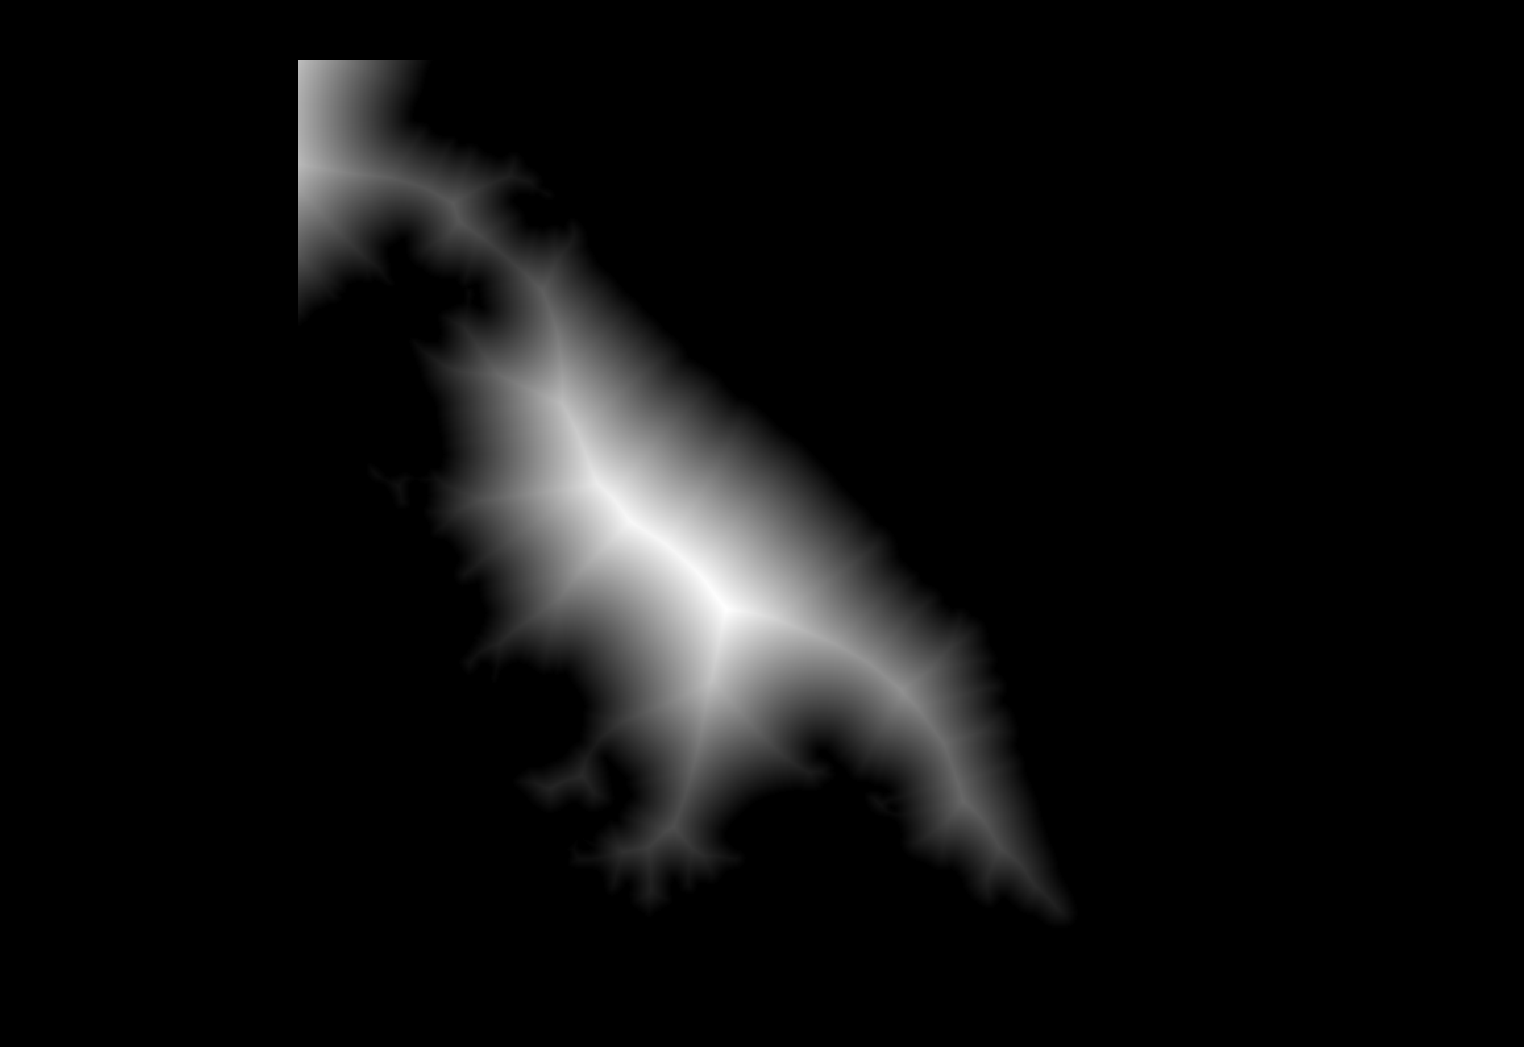

In [45]:
# apply a euclidian distance transform for the cellmask projection; brightness represents the distance from the edge of the cell
test_d_to_edge = centrosome.cpmorphology.distance_to_edge(test_labels)
viewer.add_image(test_d_to_edge)
nbscreenshot(viewer, canvas_only=True)

#### 2b. Create a representation of pixels within the cell mask based on how far they are from the center of our "centering object". Here we are using the nucleus, but the center of the cell mask could also work.

In [46]:
# this lists the pixel counts for each cell mask in the image
test_center_labels = label(test_center_objects)
test_pixel_counts = centrosome.cpmorphology.fixup_scipy_ndimage_result(ndi_sum(np.ones(test_center_labels.shape), 
                                                                               test_center_labels, 
                                                                               np.arange(1, np.max(test_center_labels) + 1, dtype=np.int32),
                                                                               ))
test_good = test_pixel_counts > 0

# list the XY coordinates (i,j) of the center of the centering object (nucleus in our case)
test_i, test_j = (centrosome.cpmorphology.centers_of_labels(test_center_labels) + 0.5).astype(int)

test_ig = test_i[test_good]
test_jg = test_j[test_good]

test_lg = np.arange(1, len(test_i) + 1)[test_good]

In [47]:
# Reduce the propagation labels to the centers of the centering objects (nucleus); True = use center of centering to start bin creation; False = use edge of centering object to propogate bins out
test_center_on_nuc = False 

if test_center_on_nuc:
    test_center_labels = np.zeros(test_center_labels.shape, int)
    test_center_labels[test_ig, test_jg] = test_lg

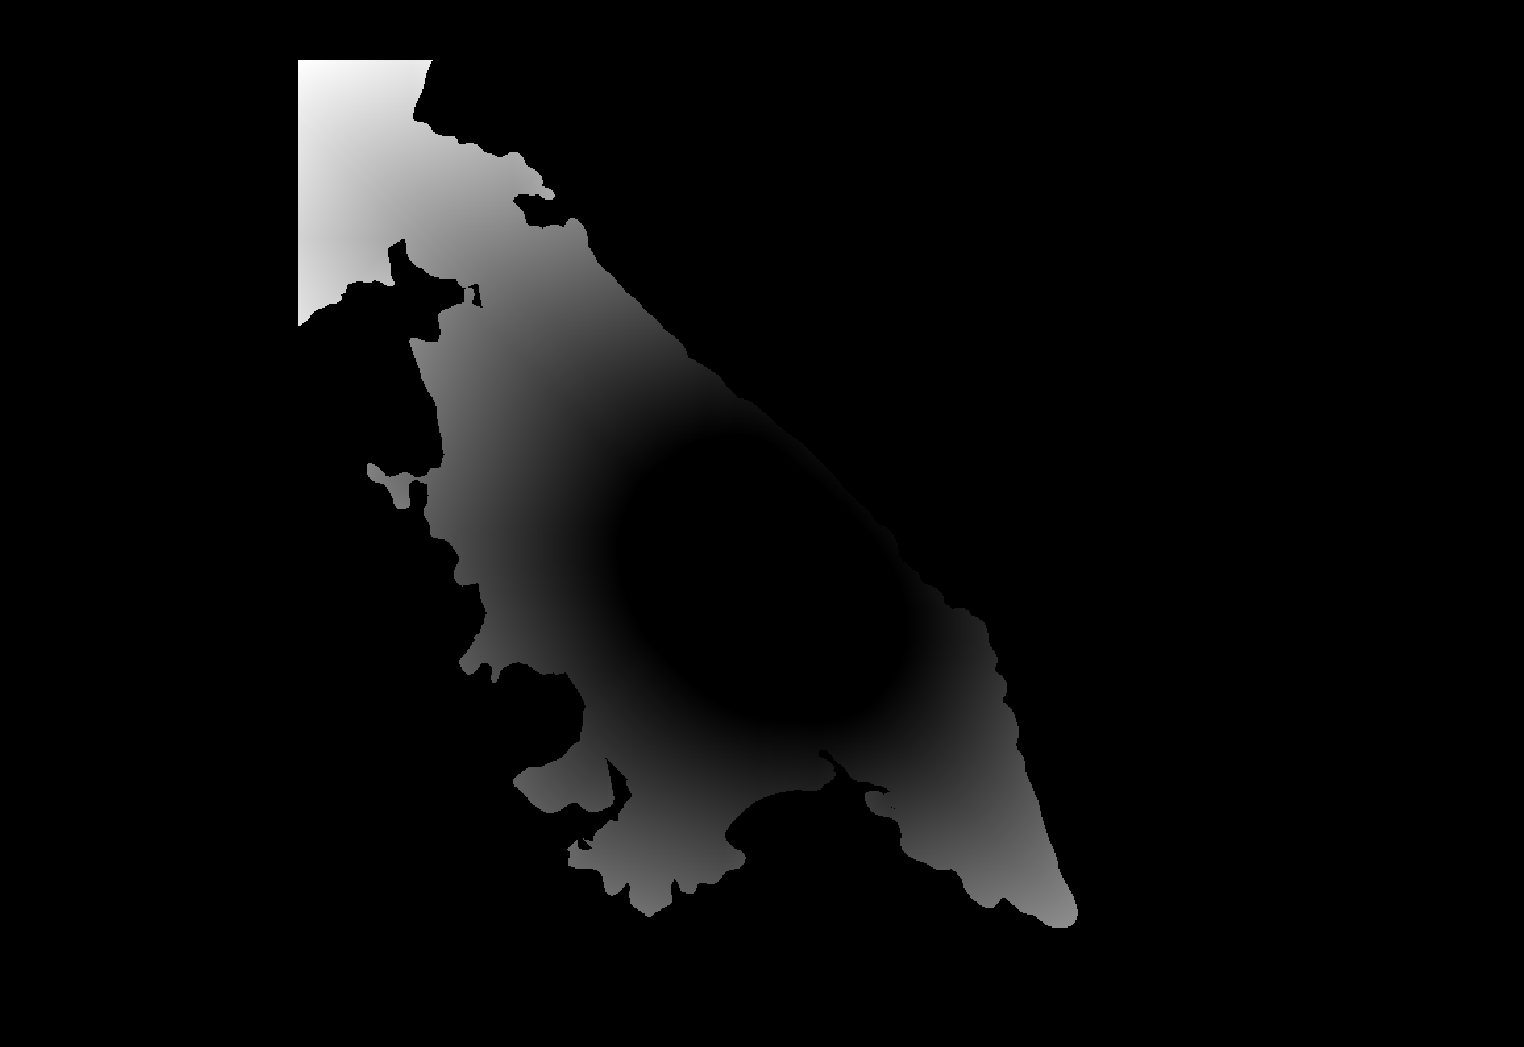

In [48]:
# propogates distances out from the center of the nucleus; brightest pixels are furthest away from nucleus
test_cl, test_d_from_center = centrosome.propagate.propagate(np.zeros(test_center_labels.shape), test_center_labels, test_labels != 0, 1)
test_cl[test_labels == 0] = 0 # apply the mask 

viewer.add_image(test_cl)
viewer.add_image(test_d_from_center)
nbscreenshot(viewer, canvas_only=True)

#### 2c. Make sure that each cell mask has a centering object and create a final projection cell mask that will be used downstream.

In [49]:
# test for missing nucleus within the cell mask; most important when there are more than one object (cell) in the image
test_missing_mask = (test_labels != 0) & (test_cl == 0)
test_missing_labels = np.unique(test_labels[test_missing_mask])

if len(test_missing_labels):
            print("WTF!!  how did we have missing labels?")
            test_all_centers = centrosome.cpmorphology.centers_of_labels(test_labels)
            test_missing_i_centers, test_missing_j_centers = test_all_centers[:, test_missing_labels-1]
            test_di = test_missing_i_centers[:, np.newaxis] - test_ig[np.newaxis, :]
            test_dj = test_missing_j_centers[:, np.newaxis] - test_jg[np.newaxis, :]
            test_missing_best = test_lg[np.argsort(test_di * test_di + test_dj * test_dj)[:, 0]]
            test_best = np.zeros(np.max(test_labels) + 1, int)
            test_best[test_missing_labels] = test_missing_best
            test_cl[test_missing_mask] = test_best[test_labels[test_missing_mask]]

            # Now compute the crow-flies distance to the centers of these pixels from whatever center was assigned to the object.
            test_iii, test_jjj = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]]
            test_di = test_iii[test_missing_mask] - test_i[test_cl[test_missing_mask] - 1]
            test_dj = test_jjj[test_missing_mask] - test_j[test_cl[test_missing_mask] - 1]
            test_d_from_center[test_missing_mask] = np.sqrt(test_di * test_di + test_dj * test_dj)

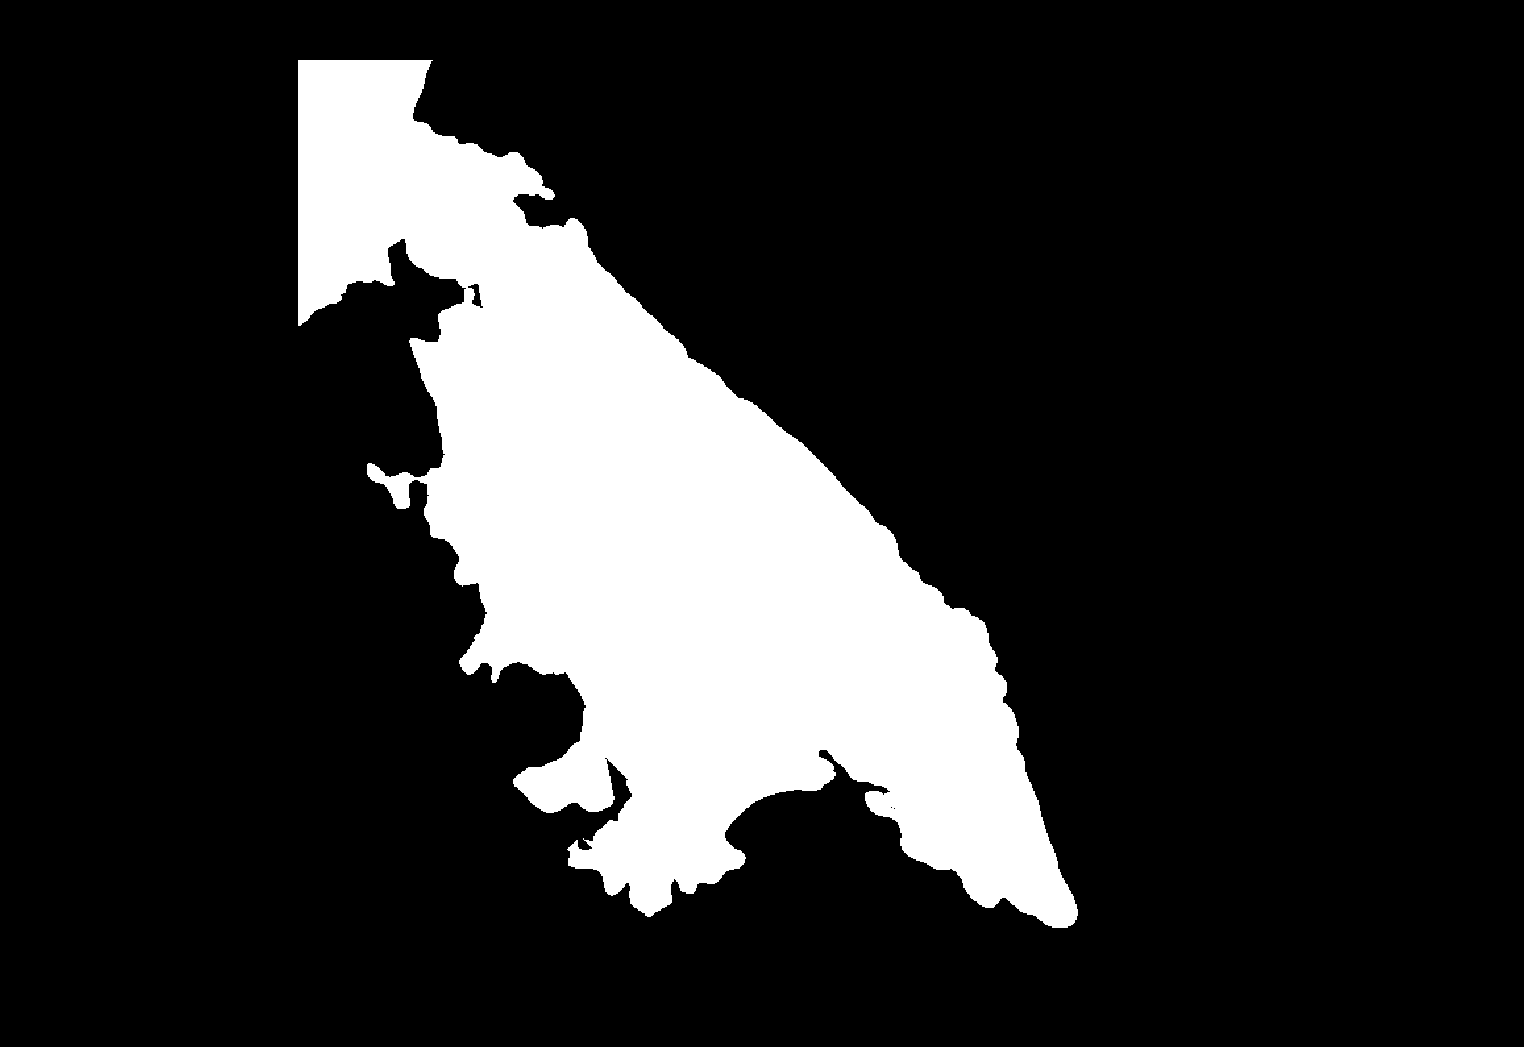

In [50]:
# create the projection cell mask that appropriately includes a centering cell mask
test_good_mask = test_cl > 0

viewer.add_image(test_good_mask)
nbscreenshot(viewer, canvas_only=True)

#### 2d. Decide how the cell area should be separated into bins (including or exclusing the centering object) and combining the two representations created above to produce one normalized representation of the distance between the centering object and the edge of the cell mask.

In [51]:
# Deciding if the nucleus (our centering object) will be the first bin or not if it will be excluded 
# In our case, "stuff" may lie above or below the nucleus in 3D which will appear within the nucleus area after sum projection
# False = do not include the nucleus as the first bin
test_keep_nuc_bins = True

if not test_keep_nuc_bins:
    # include pixels within the centering objects
    # when performing calculations from the centers
    test_good_mask = test_good_mask & (test_center_labels == 0)

In [52]:
# creating an object equal to the cellmask_proj with all pixel values equal to the X coordinate value (here called 'i')
test_i_center = np.zeros(test_cl.shape)
test_i_center[test_good_mask] = test_i[test_cl[test_good_mask] - 1]

# creating an object equal to the cellmask_proj with all pixel values equal to the Y coordinate value (here called 'j')
test_j_center = np.zeros(test_cl.shape)
test_j_center[test_good_mask] = test_j[test_cl[test_good_mask] - 1]

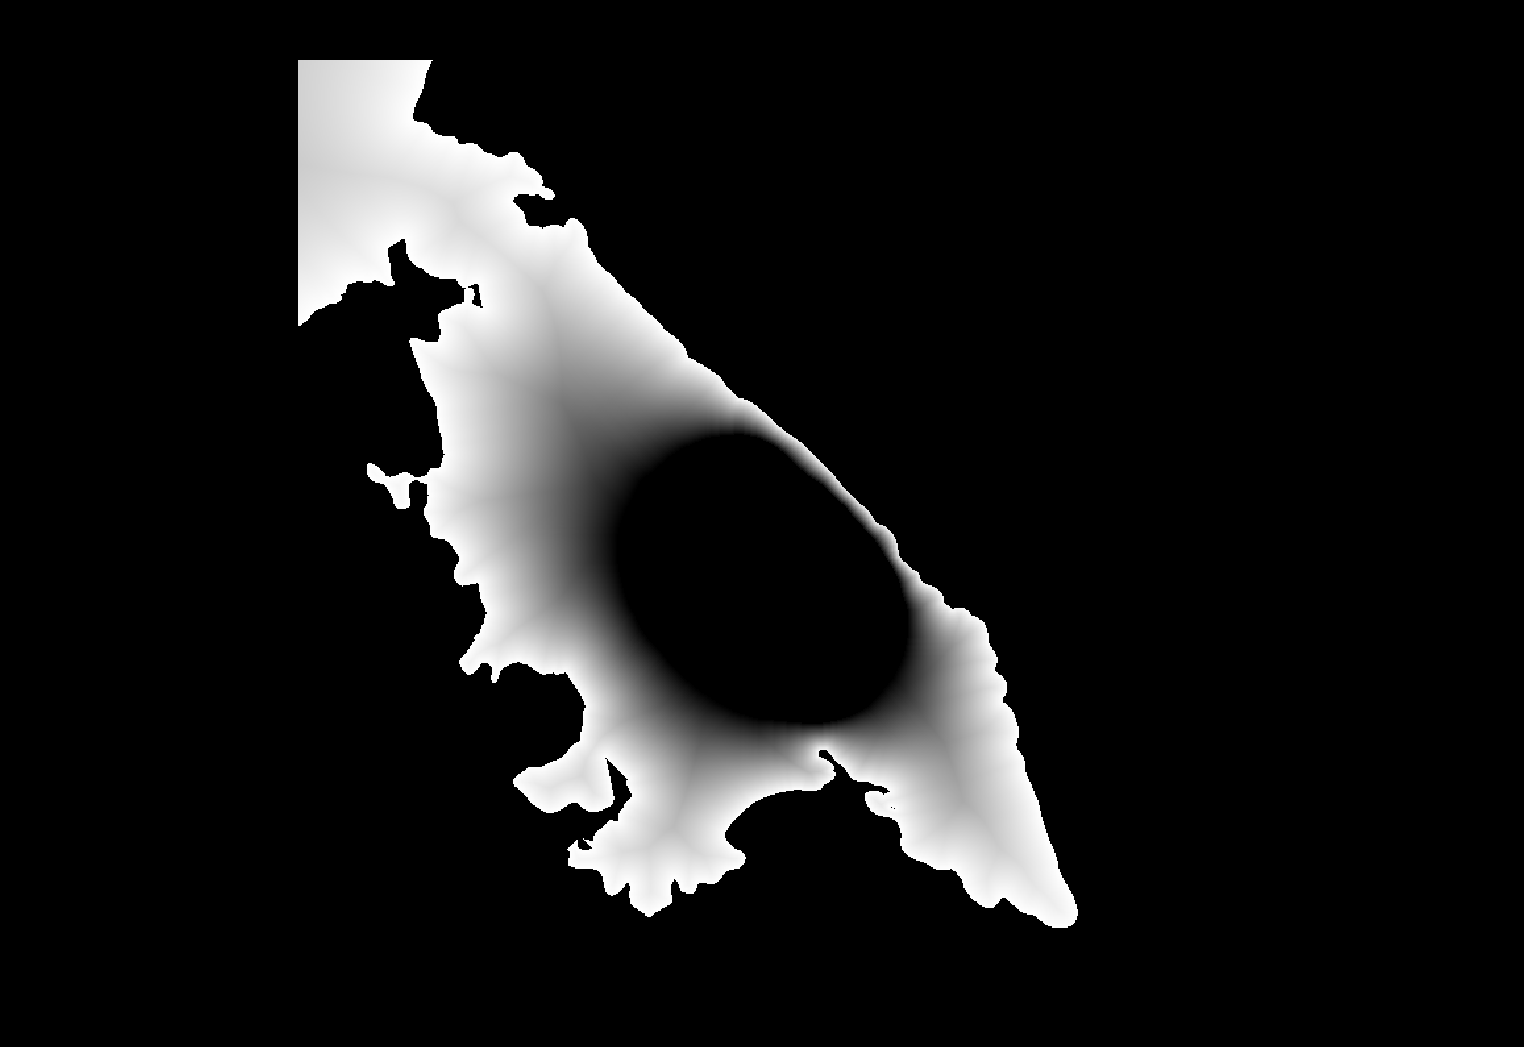

In [53]:
# creating normalized radial distance out from nucleus to edge of cell
test_normalized_distance = np.zeros(test_labels.shape) # creat an empty array
test_total_distance = test_d_from_center + test_d_to_edge # add the two distance arrays together
test_normalized_distance[test_good_mask] = test_d_from_center[test_good_mask] / ( test_total_distance[test_good_mask] + 0.001 )

viewer.add_image(test_normalized_distance)
nbscreenshot(viewer, canvas_only=True)

#### Define `get_normalized_distance_and_mask()` function.

Combine all of the above code into a function to define the normalized distances from the centering object to the edge of the cell mask and create a final projection cell mask to use downstream.

In [54]:
def _get_normalized_distance_and_mask(labels, center_objects, center_on_nuc, keep_nuc_bins):
    """
    helper for radial distribution
    """
    d_to_edge = centrosome.cpmorphology.distance_to_edge(labels) # made a local version
    ## use the nucleus as the center 
    if center_objects is not None:
        # don't need to do this size_similarity trick.  I KNOW that labels and center_objects are the same size
        # center_labels, cmask = size_similarly(labels, center_objects)
        # going to leave them as labels, so in principle the same code could work for partitioned masks (labels)
        center_labels = label(center_objects)
        pixel_counts = centrosome.cpmorphology.fixup_scipy_ndimage_result(
                            ndi_sum(
                                np.ones(center_labels.shape),
                                center_labels,
                                np.arange(
                                    1, np.max(center_labels) + 1, dtype=np.int32
                                ),
                            )
                        )
        good = pixel_counts > 0
        i, j = ( centrosome.cpmorphology.centers_of_labels(center_labels) + 0.5).astype(int)
        ig = i[good]
        jg = j[good]
        lg = np.arange(1, len(i) + 1)[good]
        
        if center_on_nuc:  # Reduce the propagation labels to the centers of the centering objects
            center_labels = np.zeros(center_labels.shape, int)
            center_labels[ig, jg] = lg


        cl, d_from_center = centrosome.propagate.propagate(  np.zeros(center_labels.shape), center_labels, labels != 0, 1)
        cl[labels == 0] = 0            # Erase the centers that fall outside of labels


        # SHOULD NEVER NEED THIS because we arent' looking at multiple
        # If objects are hollow or crescent-shaped, there may be objects without center labels. As a backup, find the
        # center that is the closest to the center of mass.
        missing_mask = (labels != 0) & (cl == 0)
        missing_labels = np.unique(labels[missing_mask])
        
        if len(missing_labels):
            print("WTF!!  how did we have missing labels?")
            all_centers = centrosome.cpmorphology.centers_of_labels(labels)
            missing_i_centers, missing_j_centers = all_centers[:, missing_labels-1]
            di = missing_i_centers[:, np.newaxis] - ig[np.newaxis, :]
            dj = missing_j_centers[:, np.newaxis] - jg[np.newaxis, :]
            missing_best = lg[np.argsort(di * di + dj * dj)[:, 0]]
            best = np.zeros(np.max(labels) + 1, int)
            best[missing_labels] = missing_best
            cl[missing_mask] = best[labels[missing_mask]]

            # Now compute the crow-flies distance to the centers of these pixels from whatever center was assigned to the object.
            iii, jjj = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]
            di = iii[missing_mask] - i[cl[missing_mask] - 1]
            dj = jjj[missing_mask] - j[cl[missing_mask] - 1]
            d_from_center[missing_mask] = np.sqrt(di * di + dj * dj)

        good_mask = cl > 0

        if not keep_nuc_bins:
            # include pixels within the centering objects
            # when performing calculations from the centers
            good_mask = good_mask & (center_labels == 0)
            
    else: # ELSE     if center_objects is  None so center on the middle of the cellmask_mask
        i, j = centrosome.cpmorphology.maximum_position_of_labels(   d_to_edge, labels, [1])
        center_labels = np.zeros(labels.shape, int)
        center_labels[i, j] = labels[i, j]
        # Use the coloring trick here to process touching objectsin separate operations
        colors = centrosome.cpmorphology.color_labels(labels)
        ncolors = np.max(colors)
        d_from_center = np.zeros(labels.shape)
        cl = np.zeros(labels.shape, int)

        for color in range(1, ncolors + 1):
            mask = colors == color
            l, d = centrosome.propagate.propagate( np.zeros(center_labels.shape), center_labels, mask, 1)
            d_from_center[mask] = d[mask]
            cl[mask] = l[mask]

        good_mask = cl > 0

    ## define spatial distribution from masks
    # collect arrays of centers
    i_center = np.zeros(cl.shape)
    i_center[good_mask] = i[cl[good_mask] - 1]
    j_center = np.zeros(cl.shape)
    j_center[good_mask] = j[cl[good_mask] - 1]

    normalized_distance = np.zeros(labels.shape)
    total_distance = d_from_center + d_to_edge

    normalized_distance[good_mask] = d_from_center[good_mask] / ( total_distance[good_mask] + 0.001 )
    return normalized_distance, good_mask, i_center, j_center

In [55]:
test_normalized_distance_a, test_good_mask_a, test_i_center_a, test_j_center_a = _get_normalized_distance_and_mask(labels=test_labels,
                                                                                                                  center_objects=test_center_objects,
                                                                                                                  center_on_nuc=False,
                                                                                                                  keep_nuc_bins=True)

In [56]:
np.array_equal(test_normalized_distance, test_normalized_distance_a), np.array_equal(test_good_mask, test_good_mask_a), np.array_equal(test_i_center, test_i_center_a), np.array_equal(test_j_center, test_j_center_a)

(True, True, True, True)

#### Add prototype function into `stats.py`

In [57]:
from infer_subc.utils.stats import get_normalized_distance_and_mask

test_normalized_distance_final, test_good_mask_final, test_i_center_final, test_j_center_final = _get_normalized_distance_and_mask(labels=test_labels,
                                                                                                                  center_objects=test_center_objects,
                                                                                                                  center_on_nuc=False,
                                                                                                                  keep_nuc_bins=True)

np.array_equal(test_normalized_distance, test_normalized_distance_final), np.array_equal(test_good_mask, test_good_mask_final), np.array_equal(test_i_center, test_i_center_final), np.array_equal(test_j_center, test_j_center_final)

(True, True, True, True)

### 3. Create concentric rings based on the normalized distance image created above and collect measurements of organelle distribution within those rings. 

The rings will be our "bins" to measure from.

#### 3a. Create a specified number of concentric rings from the normalized distances created above.

In [58]:
# we want 5 total bins
test_bin_count = 5 

test_ngood_pixels = np.sum(test_good_mask)
test_good_labels = test_labels[test_good_mask]

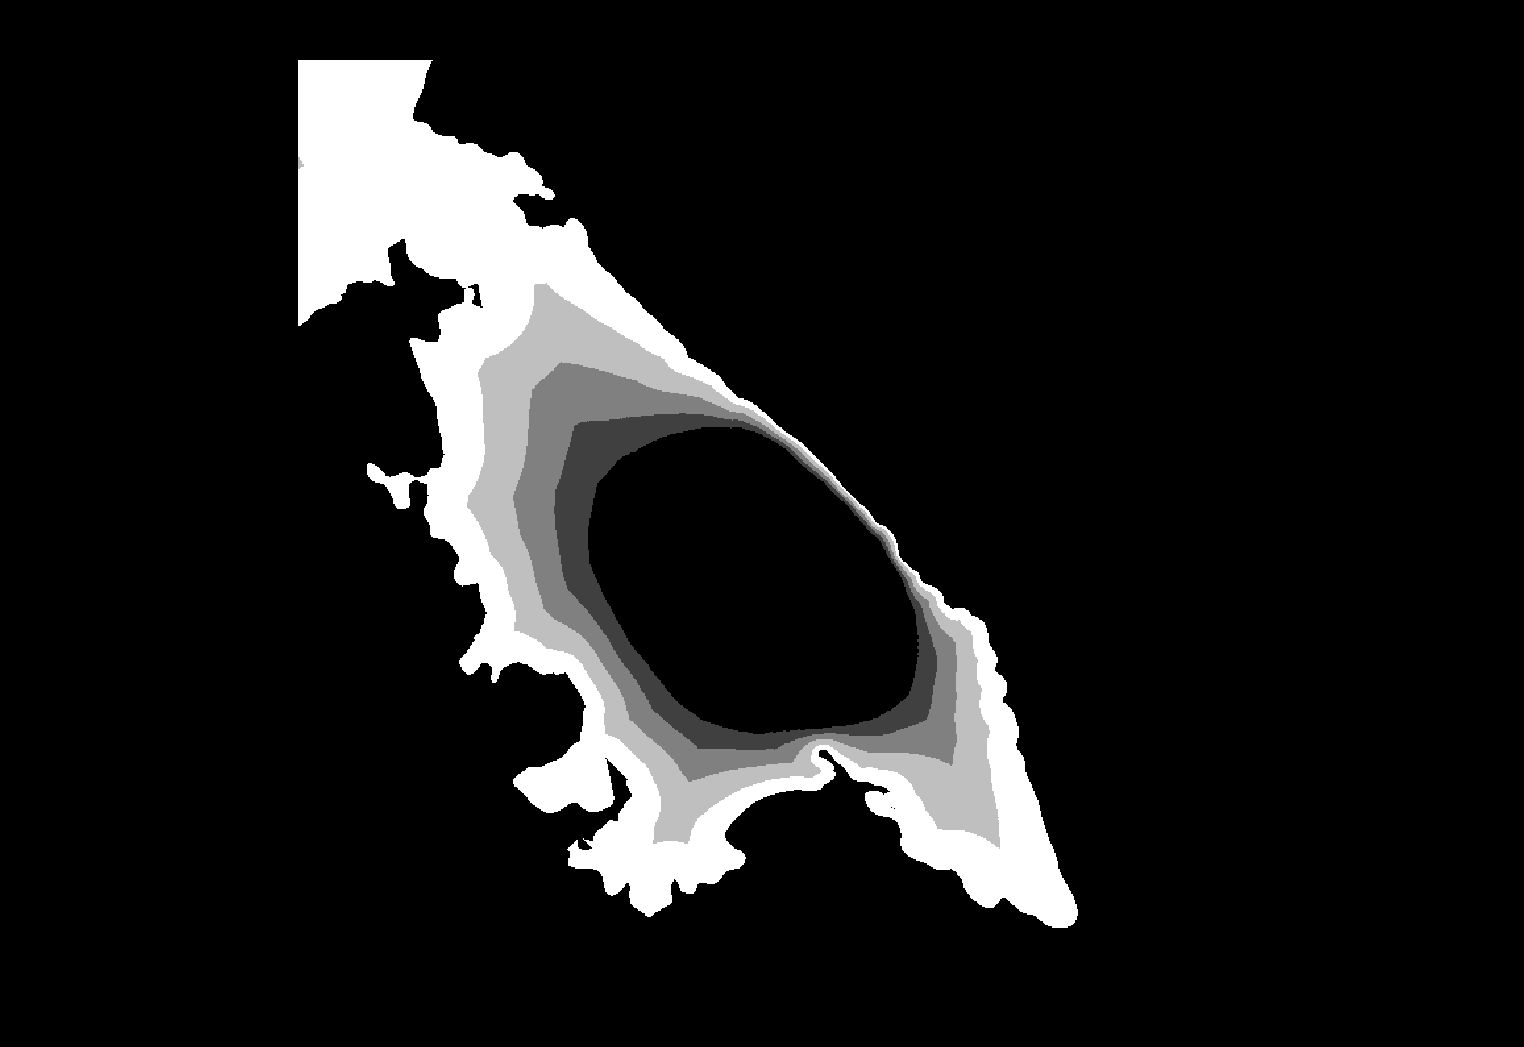

In [59]:
test_bin_indexes = (test_normalized_distance * test_bin_count).astype(int)
test_bin_indexes[test_bin_indexes > test_bin_count] = test_bin_count

viewer.add_image(test_bin_indexes)
nbscreenshot(viewer, canvas_only=True)

#### 3b. collect information from each bin

In [60]:
test_labels_and_bins = (test_good_labels - 1, test_bin_indexes[test_good_mask])

test_nobjects = 1 # to define there is only one cell being measured from I think

# get count of voxels in each bin from the following images
test_histogram_cmsk = coo_matrix( (test_cell_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count) ).toarray()
test_histogram_org = coo_matrix(  (test_golgi_proj_a[test_good_mask], test_labels_and_bins), shape=(test_nobjects, test_bin_count) ).toarray()

# total voxel counts for the entire cell (should be the same as the volume for each of these things)
test_sum_by_object_cmsk = np.sum(test_histogram_cmsk, 1) # flattened cellmask voxel count
test_sum_by_object_org = np.sum(test_histogram_org, 1)  # organelle voxel count

In [61]:
test_bin_indexes = (test_normalized_distance * test_bin_count).astype(int)

# get number of XY pixels in each bin
test_number_at_distance = coo_matrix(( np.ones(test_ngood_pixels), test_labels_and_bins), (test_nobjects, test_bin_count)).toarray()

# total pixels in XY cell area 
test_sum_by_object = np.sum(test_number_at_distance, 1)

# get the proportion of pixels in each bin (*100 to get percentage of cell pixels per bin)
test_sum_by_object_per_bin = np.dstack([test_sum_by_object] * (test_bin_count))[0]
test_fraction_at_bin = test_number_at_distance / test_sum_by_object_per_bin


In [62]:
# getting radial index for each pixel??
test_i, test_j = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]] # intensity gradients of pixels in X (top to bottom) and then Y (left to right)
test_imask = test_i[test_good_mask] > test_i_center[test_good_mask]
test_jmask = test_j[test_good_mask] > test_j_center[test_good_mask]
test_absmask = abs(test_i[test_good_mask] - test_i_center[test_good_mask]) > abs(test_j[test_good_mask] - test_j_center[test_good_mask])
test_radial_index = (test_imask.astype(int) + test_jmask.astype(int) * 2 + test_absmask.astype(int) * 4)

#### 3c. Summarize the distribution data into one table

In [63]:
# collecting all of the information above into one place:
test_statistics = []
test_stat_names =[]
test_cv_cmsk = []
test_cv_obj = []
test_cv_img = []

for bin in range(test_bin_count):
    test_bin_mask = test_good_mask & (test_bin_indexes == bin)
    test_bin_pixels = np.sum(test_bin_mask)

    test_bin_labels = test_labels[test_bin_mask]

    test_bin_radial_index = test_radial_index[test_bin_indexes[test_good_mask] == bin]
    test_labels_and_radii = (test_bin_labels - 1, test_bin_radial_index)
    test_pixel_count = coo_matrix( (np.ones(test_bin_pixels), test_labels_and_radii), (test_nobjects, 8) ).toarray()

    test_radial_counts_cmsk = coo_matrix( (test_cell_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray()
    test_radial_counts = coo_matrix( (test_golgi_proj_a[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray()
    # test_radial_values = coo_matrix( (test_cellmask_proj[test_bin_mask], test_labels_and_radii), (test_nobjects, 8) ).toarray()

    # we might need the masked arrays for some organelles... but I think not. keeping for now
    test_mask = test_pixel_count == 0

    test_radial_means_cmsk = np.ma.masked_array(test_radial_counts_cmsk / test_pixel_count, test_mask)
    test_radial_cv_cmsk = np.std(test_radial_means_cmsk, 1) / np.mean(test_radial_means_cmsk, 1)
    test_radial_cv_cmsk[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_cmsk.mask = np.sum(~test_mask, 1) == 0


    test_radial_means_obj = np.ma.masked_array(test_radial_counts / test_pixel_count, test_mask)
    test_radial_cv_obj = np.std(test_radial_means_obj, 1) / np.mean(test_radial_means_obj, 1)
    test_radial_cv_obj[np.sum(~test_mask, 1) == 0] = 0
    test_radial_cv_obj.mask = np.sum(~test_mask, 1) == 0

    # test_radial_means_img = np.ma.masked_array(test_radial_values / test_pixel_count, test_mask)
    # test_radial_cv_img = np.std(test_radial_means_img, 1) / np.mean(test_radial_means_img, 1)
    # test_radial_cv_img[np.sum(~test_mask, 1) == 0] = 0
    # test_radial_cv_img.mask = np.sum(~test_mask, 1) == 0

    # test_bin_name = str(bin) if bin > 0 else "Ctr"
    test_bin_name = str(bin + 1) if bin > 0 else "1"

    # # there's gotta be a better way to collect this stuff together... pandas?
    # statistics += [
    #     (   bin_name,
    #         # np.mean(number_at_distance[:, bin]), 
    #         # np.mean(histogram_cmsk[:, bin]), 
    #         # np.mean(histogram_org[:, bin]), 
    #         # np.mean(histogram_img[:, bin]), 
    #         np.mean(radial_cv_cmsk) ,
    #         np.mean(radial_cv_obj) ,
    #         np.mean(radial_cv_img) )
    # ]
    test_stat_names.append(test_bin_name)
    test_cv_cmsk.append(float(np.mean(test_radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
    test_cv_obj.append(float(np.mean(test_radial_cv_obj)))
    # test_cv_img.append(float(np.mean(test_radial_cv_obj)))

In [64]:
test_org_name = 'golgi'

test_stats_dict={'organelle': test_org_name,
            'XY_n_bins': test_bin_count,
            'XY_bins': [test_stat_names],
            'XY_cm_vox_cnt': [test_histogram_cmsk.squeeze().tolist()],
            'XY_org_vox_cnt': [test_histogram_org.squeeze().tolist()],
            'XY_n_pix': [test_number_at_distance.squeeze().tolist()],
            'XY_cm_cv':[test_cv_cmsk],
            'XY_org_cv':[test_cv_obj]
            }

test_stat_tab = pd.DataFrame(test_stats_dict)

test_stat_tab

,organelle,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_cv,XY_org_cv
0,golgi,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


#### Define `get_concentric_distribution()` function

Based on the *prototyping* above, define the function to create a specific number of bins and measure object distribution within them.

In [65]:
def _get_concentric_distribution(
        cellmask_proj: np.ndarray,
        nucleus_proj: np.ndarray,
        org_proj: np.ndarray,
        org_name: str,
        bin_count: Union[int, None] = 5,
        center_obj_as_bin: bool = True,
        bins_from_center:bool = False
    ):
    """
    Based on CellProfiler's measureobjectintensitydistribution. Measure the distribution of segmented objects within a masked area. 
    In our case, we will usually utilize this function to measure the amount of an organelle within the cell.
    Radial bins are created out from a center point, usually the nucleus edge.

    Parameters
    ------------
    cellmask_proj: np.ndarray
        a sum projection of the segmented cell area where the "intensity" value of each pixel is equal to the number of z slices where the binary cell mask is True
    nucleus_proj: np.ndarray
        a sum projection of the segmented nucleus area where the "intensity" value of each pixel is equal to the number of z slices where the binary nucleus mask is True
    org_proj: np.ndarray,
        a sum projection of the segmented organelle area where the "intensity" value of each pixel is equal to the number of z slices where the binary organelle mask is True
    org_name: str,
        the name or nickname of your organelle; used for labeling columns in the dataframe
    bin_count: Union[int, None] = 5,
        the number of bins to create within the cell mask
    center_obj_as_bin: bool = True,
        True = include the centering object area when creating the bins
        False = do not include the centering object area when creating the bins
    bins_from_center:bool = False
        True = distribute the bins from the center of the centering object
    masked


    Returns
    -------------
    returns one statistics table (pd.DataFrame) + bin_array (np.ndarray) image
    """

    # other parameters that will stay constant
    nobjects = 1

    # create binary arrays
    center_objects = nucleus_proj>0 
    cellmask = (cellmask_proj>0).astype(np.uint16)


    ################   ################
    ## define masks for computing distances
    ################   ################
    normalized_distance, good_mask, i_center, j_center = get_normalized_distance_and_mask(cellmask, center_objects, bins_from_center, center_obj_as_bin)
    
    if normalized_distance is None:
        print('WTF!!  normalized_distance returned wrong')

    ################   ################
    ## get histograms
    ################   ################
    ngood_pixels = np.sum(good_mask)
    good_labels = cellmask[good_mask]

    # protect against None normaized_distances
    bin_array = (normalized_distance * bin_count).astype(int)
    bin_array[bin_array > bin_count] = bin_count # shouldn't do anything

    #                 (    i          ,         j              )
    labels_and_bins = (good_labels - 1, bin_array[good_mask])

    #                coo_matrix( (             data,             (i, j)    ), shape=                      )
    histogram_cmsk = coo_matrix( (cellmask_proj[good_mask], labels_and_bins), shape=(nobjects, bin_count) ).toarray()
    histogram_org = coo_matrix(  (org_proj[good_mask],      labels_and_bins), shape=(nobjects, bin_count) ).toarray()

    bin_array = (normalized_distance * bin_count).astype(int)

    sum_by_object_cmsk = np.sum(histogram_cmsk, 1) # flattened cellmask voxel count
    sum_by_object_org = np.sum(histogram_org, 1)  # organelle voxel count


    # DEPRICATE: since we are NOT computing object_i by object_i (individual organelle labels)
    # sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count + 1))[0]
    # fraction_at_distance = histogram / sum_by_object_per_bin

    # number of bins.
    number_at_distance = coo_matrix(( np.ones(ngood_pixels), labels_and_bins), (nobjects, bin_count)).toarray()

    # sicne we aren't breaking objects apart this is just ngood_pixels

    sum_by_object = np.sum(number_at_distance, 1)

    sum_by_object_per_bin = np.dstack([sum_by_object] * (bin_count))[0]
    fraction_at_bin = number_at_distance / sum_by_object_per_bin # sums to 1.0

    # object_mask = number_at_distance > 0
    # DEPRICATE:# not doing over multiple objects so don't need object mask.. or fractionals
    # mean_pixel_fraction = fraction_at_distance / ( fraction_at_bin + np.finfo(float).eps )
    # masked_fraction_at_distance = np.ma.masked_array( fraction_at_distance, ~object_mask )
    # masked_mean_pixel_fraction = np.ma.masked_array(mean_pixel_fraction, ~object_mask)

    ################   ################
    ## collect Anisotropy calculation.  + summarize
    ################   ################
    # Split each cell into eight wedges, then compute coefficient of variation of the wedges' mean intensities
    # in each ring. Compute each pixel's delta from the center object's centroid
    i, j = np.mgrid[0 : cellmask.shape[0], 0 : cellmask.shape[1]]
    imask = i[good_mask] > i_center[good_mask]
    jmask = j[good_mask] > j_center[good_mask]
    absmask = abs(i[good_mask] - i_center[good_mask]) > abs(j[good_mask] - j_center[good_mask])
    radial_index = (imask.astype(int) + jmask.astype(int) * 2 + absmask.astype(int) * 4)

    # return radial_index, labels, good_mask, bin_indexes
    stat_names =[]
    cv_cmsk = []
    cv_obj = []

    # collect the numbers from each "bin"
    for bin in range(bin_count):
        bin_mask = good_mask & (bin_array == bin)
        bin_pixels = np.sum(bin_mask)

        bin_labels = cellmask[bin_mask]

        bin_radial_index = radial_index[bin_array[good_mask] == bin]
        labels_and_radii = (bin_labels - 1, bin_radial_index)
        pixel_count = coo_matrix( (np.ones(bin_pixels), labels_and_radii), (nobjects, 8) ).toarray()

        radial_counts_cmsk = coo_matrix( (cellmask_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        radial_counts = coo_matrix( (org_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()
        # radial_values = coo_matrix( (img_proj[bin_mask], labels_and_radii), (nobjects, 8) ).toarray()

        # we might need the masked arrays for some organelles... but I think not. keeping for now
        mask = pixel_count == 0

        radial_means_cmsk = np.ma.masked_array(radial_counts_cmsk / pixel_count, mask)
        radial_cv_cmsk = np.std(radial_means_cmsk, 1) / np.mean(radial_means_cmsk, 1)
        radial_cv_cmsk[np.sum(~mask, 1) == 0] = 0
        radial_cv_cmsk.mask = np.sum(~mask, 1) == 0


        radial_means_obj = np.ma.masked_array(radial_counts / pixel_count, mask)
        radial_cv_obj = np.std(radial_means_obj, 1) / np.mean(radial_means_obj, 1)
        radial_cv_obj[np.sum(~mask, 1) == 0] = 0
        radial_cv_obj.mask = np.sum(~mask, 1) == 0

        bin_name = str(bin + 1) if bin > 0 else "1"

        stat_names.append(bin_name)
        cv_cmsk.append(float(np.mean(radial_cv_cmsk)))  #convert to float to make importing from csv more straightforward
        cv_obj.append(float(np.mean(radial_cv_obj)))
    
    stats_dict={'organelle': org_name,
                'XY_n_bins': bin_count,
                'XY_bins': [stat_names],
                'XY_cm_vox_cnt': [histogram_cmsk.squeeze().tolist()],
                'XY_org_vox_cnt': [histogram_org.squeeze().tolist()],
                'XY_n_pix': [number_at_distance.squeeze().tolist()],
                'XY_cm_cv':[cv_cmsk],
                'XY_org_cv':[cv_obj]}

    # stats_tab = pd.DataFrame(statistics,columns=col_names)
    stats_tab = pd.DataFrame(stats_dict)  
    return stats_tab, bin_array

In [66]:
test_stats_tab_a, test_bin_indexes_a = _get_concentric_distribution(cellmask_proj=test_cell_proj_a, 
                                                            nucleus_proj=test_nuc_proj_a, 
                                                            org_proj=test_golgi_proj_a, 
                                                            org_name='golgi', 
                                                            bin_count=5, 
                                                            center_obj_as_bin=True,
                                                            bins_from_center=False)

test_stats_tab_a

,organelle,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_cv,XY_org_cv
0,golgi,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


In [67]:
test_stats_tab_a.equals(test_stat_tab)

True

#### Add prototype function into `stats.py`

In [68]:
from infer_subc.utils.stats import get_concentric_distribution

test_stats_tab_final, bin_image_final = get_concentric_distribution(cellmask_proj=test_cell_proj_a, 
                                        nucleus_proj=test_nuc_proj_a, 
                                        org_proj=test_golgi_proj_a, 
                                        org_name='golgi', 
                                        bin_count=5, 
                                        center_obj_as_bin=True,
                                        bins_from_center=False)

test_stats_tab_a.equals(test_stats_tab_final)

True

In [69]:
test_stats_tab_final

,organelle,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_cv,XY_org_cv
0,golgi,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


### 4. Collect measurement about the distribution the organelles within each bin using zernike features

#### 4a. Specify the number of degress to use for calculating zernike features

In [70]:
test_labels = label(test_cell_proj_a>0)

# get the zernike indexes based on the number of degrees chosen
test_zernike_degree = 9
test_zernike_indexes = centrosome.zernike.get_zernike_indexes( test_zernike_degree + 1)

In [71]:
# get the center of the cell mask and the radius of the minimum enclosed circle
test_ij, test_r = centrosome.cpmorphology.minimum_enclosing_circle( test_labels )

# create a gradient of intensities in X and Y
test_iii, test_jjj = np.mgrid[0 : test_labels.shape[0], 0 : test_labels.shape[1]]

# normalize those values using the center of the cell and radius calculated above
test_iii = (test_iii-test_ij[0][0] ) / test_r
test_jjj = (test_jjj-test_ij[0][1] ) / test_r

# create the zernike polynomials
test_z = centrosome.zernike.construct_zernike_polynomials(test_iii, test_jjj, test_zernike_indexes)

#### Define `zernike_polynomial()` function

Based on the prototyping above, define the function to create zernike polynomials

In [72]:
def _zernike_polynomial(labels, zernike_is):
    """
    

    """
    # First, get a table of centers and radii of minimum enclosing
    # circles for the cellmask
    ij, r = centrosome.cpmorphology.minimum_enclosing_circle( labels )
    # Then compute x and y, the position of each labeled pixel
    # within a unit circle around the object
    iii, jjj = np.mgrid[0 : labels.shape[0], 0 : labels.shape[1]]

    # translate+scale
    iii = (iii-ij[0][0] ) / r
    jjj = (jjj-ij[0][1] ) / r

    z = centrosome.zernike.construct_zernike_polynomials(
        iii, jjj, zernike_is
    )
    return z

In [73]:
test_z_a = _zernike_polynomial(test_labels, test_zernike_indexes)

np.array_equal(test_z, test_z_a)

True

#### `TODO: include an image of the zerinke pies for the entire cell`

In [74]:
viewer.close()

#### Add the prototype function into `stats.py`

In [75]:
from infer_subc.utils.stats import zernike_polynomial

test_z_final = zernike_polynomial(test_labels, test_zernike_indexes)

np.array_equal(test_z, test_z_final)

True

#### 4b. collect zernike measurements

In [76]:
# collecting zernike measurements for golgi example
test_vr = np.sum(test_golgi_proj_a[:,:,np.newaxis]*test_z.real, axis=(0,1))
test_vi = np.sum(test_golgi_proj_a[:,:,np.newaxis]*test_z.imag, axis=(0,1))    
test_magnitude = np.sqrt(test_vr * test_vr + test_vi * test_vi) / test_golgi_proj.sum()
test_phase = np.arctan2(test_vr, test_vi)

#### Define `zernike_stat()` function

Based on the prototyping above, defin the function to quantify zernike features for each bin.

In [77]:
def _zernike_metrics(pixels, z):
    """
    
    """
    vr = np.sum(pixels[:,:,np.newaxis]*z.real, axis=(0,1))
    vi = np.sum(pixels[:,:,np.newaxis]*z.imag, axis=(0,1))    
    magnitude = np.sqrt(vr * vr + vi * vi) / pixels.sum()
    phase = np.arctan2(vr, vi)
    return magnitude, phase

In [78]:
# collecting zernike measurements for cell and nucleus too
test_z_cm = _zernike_metrics(test_cell_proj_a, test_z)
test_z_nuc = _zernike_metrics(test_nuc_proj_a, test_z)
test_z_golgi = _zernike_metrics(test_golgi_proj_a, test_z)

In [79]:
np.array_equal(test_z_golgi[0], test_magnitude), np.array_equal(test_z_golgi[1], test_phase)

(True, True)

#### Add the function to `stats.py`

In [80]:
from infer_subc.utils.stats import zernike_metrics

test_z_golgi_final = zernike_metrics(test_golgi_proj_a, test_z)

np.array_equal(test_z_golgi, test_z_golgi_final)

True

#### 4c. Summarize the data in a data table

In [81]:
# nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
test_z_stats_tab = pd.DataFrame({'organelle':'golgi',
                            'zernike_n':[test_zernike_indexes[:,0].tolist()],
                            'zernike_m':[test_zernike_indexes[:,1].tolist()],
                            'zernike_cm_mag':[test_z_cm[0].tolist()],
                            'zernike_cm_phs':[test_z_cm[1].tolist()],   
                            'zernike_obj_mag':[test_z_golgi_final[0].tolist()],
                            'zernike_obj_phs':[test_z_golgi_final[1].tolist()],
                            'zernike_nuc_mag':[test_z_nuc[0].tolist()],
                            'zernike_nuc_phs':[test_z_nuc[1].tolist()]})

test_z_stats_tab

,organelle,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs
0,golgi,"[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57..."


#### Define `get_zernike_metics()` function

Based on the prototyping above, defin the function to quantify and summarize the zernike features

In [82]:
def _get_zernike_metrics(        
        cellmask_proj: np.ndarray,
        nucleus_proj: Union[np.ndarray, None], 
        org_proj: np.ndarray,
        organelle_name: str,
        zernike_degree: int = 9 ):

    """
    
    """

    labels = label(cellmask_proj>0) #extent as 0,1 rather than bool
    zernike_indexes = centrosome.zernike.get_zernike_indexes( zernike_degree + 1)


    z = zernike_polynomial(labels, zernike_indexes)

    z_cm = zernike_metrics(cellmask_proj, z)
    z_org = zernike_metrics(org_proj, z)
    z_nuc = zernike_metrics(nucleus_proj, z)



    # nm_labels = [f"{n}_{m}" for (n, m) in (zernike_indexes)
    stats_tab = pd.DataFrame({'organelle':organelle_name,
                                'zernike_n':[zernike_indexes[:,0].tolist()],
                                'zernike_m':[zernike_indexes[:,1].tolist()],
                                'zernike_cm_mag':[z_cm[0].tolist()],
                                'zernike_cm_phs':[z_cm[1].tolist()],   
                                'zernike_obj_mag':[z_org[0].tolist()],
                                'zernike_obj_phs':[z_org[1].tolist()],
                                'zernike_nuc_mag':[z_nuc[0].tolist()],
                                'zernike_nuc_phs':[z_nuc[1].tolist()]})

    return stats_tab

In [83]:
test_z_stats_tab_a = _get_zernike_metrics(test_cell_proj_a, test_nuc_proj_a, test_golgi_proj_a, 'golgi', 9)

In [84]:
test_z_stats_tab.equals(test_z_stats_tab_a)

True

#### Add function to `stats.py`

In [85]:
from infer_subc.utils.stats import get_zernike_metrics

test_z_stats_tab_final = get_zernike_metrics(test_cell_proj_a, test_nuc_proj_a, test_golgi_proj_a, 'golgi', 9)

test_z_stats_tab_final.equals(test_z_stats_tab_a)

True

In [86]:
test_z_stats_tab_final

,organelle,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs
0,golgi,"[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57..."


### Define `get_XY_distribution()` function

Based on the prototyping above, define the function to create the sum projections, create the normalized bins from centering object out to the edge of the cell, measure the distribution in the cell, and the zernike distribution within the bins.

In [ ]:
def _get_XY_distribution(        
        cellmask_obj: np.ndarray,
        nuclei_obj: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_name: str,
        num_bins: Union[int,None] = None,
        center_obj_as_bin=True,
        bins_from_center=False,
        zernike_degrees: Union[int,None] = None,
        ):

    """
    Params


    Returns
    -----------
    rstats table of radial distributions
    zstats table of zernike magnitudes and phases
    rad_bins image of the rstats bins over the cellmask_obj 

    """

    cell_proj = create_masked_sum_projection(cellmask_obj)
    nucleus_proj = create_masked_sum_projection(nuclei_obj,cellmask_obj.astype(bool))
    org_proj = create_masked_sum_projection(organelle_obj,cellmask_obj.astype(bool))
 

    XY_metrics, distribution_mask = get_concentric_distribution(cellmask_proj=cell_proj, 
                                                        nucleus_proj=nucleus_proj, 
                                                        org_proj=org_proj, 
                                                        org_name=organelle_name, 
                                                        bin_count=num_bins, 
                                                        center_obj_as_bin=center_obj_as_bin,
                                                        bins_from_center=bins_from_center)
    
    zernike_metrics = get_zernike_metrics(cellmask_proj=cell_proj, 
                                        org_proj=org_proj,
                                        organelle_name=organelle_name, 
                                        nucleus_proj=nucleus_proj, 
                                        zernike_degree=zernike_degrees)
    

    return XY_metrics, zernike_metrics, distribution_mask

In [ ]:
test_XY_metrics, test_zernike_metrics, test_distribution_mask = _get_XY_distribution(cell_seg,
                                                                                     nuc_seg,
                                                                                     golgi_seg,
                                                                                     'golgi',
                                                                                     5,
                                                                                     True,
                                                                                     False,
                                                                                     9)

In [ ]:
test_XY_metrics.equals(test_stats_tab_a), test_zernike_metrics.equals(test_z_stats_tab_final), np.array_equal(test_distribution_mask, test_bin_indexes_a)

### Add function to `stats.py`

In [87]:
from infer_subc.utils.stats import get_XY_distribution

test_XY_metrics_final, test_zernike_metrics_final, test_distribution_mask_final = get_XY_distribution(cell_seg,
                                                                                     nuc_seg,
                                                                                     golgi_seg,
                                                                                     'golgi',
                                                                                     5,
                                                                                     True,
                                                                                     False,
                                                                                     9)

test_XY_metrics_final.equals(test_stats_tab_a), test_zernike_metrics_final.equals(test_z_stats_tab_final), np.array_equal(test_distribution_mask_final, test_bin_indexes_a)

(True, True, True)

In [88]:
test_XY_metrics_final

,organelle,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_cv,XY_org_cv
0,golgi,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042..."


In [89]:
test_zernike_metrics_final

,organelle,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs
0,golgi,"[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57..."


### `TODO: add the scale to the distribution measures`

## Z Distribution 
Segment image in 3D;
measure area fraction of each organelle per Z slice;
these measurements will act as a frequency distribution of that organelle starting from the bottom of the cellmask (not including neurites) to the top of the cellmask;
measurements: mean, median, and standard deviation of the frequency distribution	

- pre-processing
  1. subtract nuclei from the cellmask --> cellmask cytoplasm
  2. mask organelle channels with cellmask cytoplasm mask

- per-object measurements
  - For each Z slice in the masked binary image measure:
    1. organelle area
    2. cellmask cytoplasm area

- per-object calculations
  - For each Z slice in the masked binary image: organelle area / cellmask cytoplasm area

- per cell summary
  1. create a frequency table with the z slice number on the x axis and the area fraction on the y axis
  2. Measure the frequency distribution's mean, median, and standard deviation for each cell"

### 1. Sum all True pixels in each Z slices (olong the X and Y axes)

In [90]:
raw_img_data.shape

(8, 17, 704, 704)

In [91]:
test_golgi_for_Zdist = golgi_seg.astype(bool)

test_golgi_for_Zdist_masked = apply_mask(test_golgi_for_Zdist, cell_seg)

test_golgi_for_Zdist_masked.shape

(17, 704, 704)

In [92]:
test_golgi_Zdist = test_golgi_for_Zdist_masked.sum(axis=(1,2))
test_golgi_Zdist.shape, test_golgi_Zdist

((17,),
 array([ 141,  221,  393, 1044, 1825, 2022, 1859, 1192, 1364, 1400, 1958,
        2392, 2200, 1609,  899,    0,    0]))

### Define `create_masked_depth_projection()` function

Based on the prototyping above, sum the True values along XY for every Z slice

In [93]:
def _create_masked_depth_projection(img_in:np.ndarray, mask:Union[np.ndarray, None]=None, to_bool:bool=True) -> np.ndarray:
    """
    create masked projection onto the Z dimension
    """
    img_out = img_in.astype(bool) if to_bool else img_in
    if mask is not None:
        img_out = apply_mask(img_out, mask)
    
    return img_out.sum(axis=(1,2))

In [94]:
golgi_Zdist_final = _create_masked_depth_projection(golgi_seg, cell_seg)
cell_Zdist_final = _create_masked_depth_projection(cell_seg)
nuc_Zdist_final = _create_masked_depth_projection(nuc_seg, cell_seg)

np.array_equal(test_golgi_Zdist, golgi_Zdist_final)

True

### Add function to `stats.py`

In [95]:
from infer_subc.utils.stats import create_masked_depth_projection

golgi_Zdist_final_a = create_masked_depth_projection(golgi_seg, cell_seg)

np.array_equal(golgi_Zdist_final_a, golgi_Zdist_final)

True

### 2. List the bins and summarize the data

In [96]:
# list the "bins" which in this case as the z-slices
test_z_bins = [i for i in range(cell_seg.shape[0])]
test_z_bins

[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16]

In [97]:
# summarize the Z distribution data in a table
organelle_name = 'golgi'
test_zdist_stats_tab = pd.DataFrame({'organelle':organelle_name,
                        'z_n':cell_seg.shape[0],
                        'z_slice':[test_z_bins],
                        'z_cm_vox_cnt':[cell_Zdist_final.tolist()],
                        "z_org_vox_cnt":[golgi_Zdist_final.tolist()],
                        'z_nuc_vox_cnt':[nuc_Zdist_final.tolist()]})

test_zdist_stats_tab

,organelle,z_n,z_slice,z_cm_vox_cnt,z_org_vox_cnt,z_nuc_vox_cnt
0,golgi,17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[141, 221, 393, 1044, 1825, 2022, 1859, 1192, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."


### Define `get_Z_distribution()` function

Based on the prototyping above, create projections along XY for each Z slice and sum the True pixels.

In [98]:
def _get_Z_distribution(        
        cellmask_obj: np.ndarray,
        organelle_obj:np.ndarray,
        organelle_name: str,
        nuclei_obj: Union[np.ndarray, None],
        ):
    """

    """

    # flattened
    cellmask_proj = create_masked_depth_projection(cellmask_obj)
    org_proj = create_masked_depth_projection(organelle_obj,cellmask_obj.astype(bool))

    nucleus_proj = create_masked_depth_projection(nuclei_obj,cellmask_obj.astype(bool)) if nuclei_obj is not None else None
    z_bins = [i for i in range(cellmask_obj.shape[0])]

    stats_tab = pd.DataFrame({'organelle':organelle_name,
                            'z_n':cellmask_obj.shape[0],
                            'z_slice':[z_bins],
                            'z_cm_vox_cnt':[cellmask_proj.tolist()],
                            'z_org_vox_cnt':[org_proj.tolist()],
                            'z_nuc_vox_cnt':[nucleus_proj.tolist()]})
    return stats_tab

In [99]:
zdist_stats_tab_final = _get_Z_distribution(cellmask_obj=cell_seg, organelle_name='golgi', organelle_obj=golgi_seg, nuclei_obj=nuc_seg)

In [100]:
test_zdist_stats_tab.equals(zdist_stats_tab_final)

True

### Add function to `stats.py`

In [101]:
from infer_subc.utils.stats import get_Z_distribution

zdist_stats_tab_final_a = get_Z_distribution(cellmask_obj=cell_seg, organelle_name='golgi', organelle_obj=golgi_seg, nuclei_obj=nuc_seg)

zdist_stats_tab_final_a.equals(zdist_stats_tab_final)

True

In [102]:
zdist_stats_tab_final_a

,organelle,z_n,z_slice,z_cm_vox_cnt,z_org_vox_cnt,z_nuc_vox_cnt
0,golgi,17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[141, 221, 393, 1044, 1825, 2022, 1859, 1192, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."


# putting it all together

`make_organelle_metrics_tables` prototype

### Testing how to make pairs of organelles with no redundancy

In [ ]:
test_lyso_metrics, rp = get_org_metrics_3D(lyso_seg, raw_img_data[LYSO_CH], cell_seg, scale)
test_lyso_metrics

In [103]:
# names of organelles we have
organelle_names = ["lyso", "mito","golgi","perox","ER","LD"]

# get the intensities
organelle_channels = [LYSO_CH,MITO_CH,GOLGI_CH,PEROX_CH,ER_CH,LD_CH]

# create intensities from raw as list
intensities = [raw_img_data[ch] for ch in organelle_channels]

# load organelles as list
organelles = [lyso_seg, mito_seg, golgi_seg, perox_seg, ER_seg, LD_seg]

In [ ]:
# merged_tabs = []
# for pair in test_contact_combos:

a_name = 'lyso' #pair[0]
b_name = 'mito' #pair[1]

i = organelle_names.index(a_name)
j = organelle_names.index(b_name)

a = _assert_uint16_labels(organelles[i]) # org_obj
b = _assert_uint16_labels(organelles[j])

ov = []
b_labs = []
labs = []
# for idx, lab in enumerate(a_stats_tab["label"]):  # a_stats_tab is the data associated to the a organelle collected earlier
for idx, lab in enumerate(test_lyso_metrics["label"]):
    xyz = tuple(rp[idx].coords.T) # change to xyz = tuple(rps[i].coords.T)
    cmp_org = b[xyz]
    
    # total number of overlapping pixels
    overlap = sum(cmp_org > 0)
    # overlap?
    labs_b = cmp_org[cmp_org > 0]
    b_js = np.unique(labs_b).tolist()

    # if overlap > 0:
    labs.append(id) # labs.append(lab)
    ov.append(overlap)
    b_labs.append(b_js)

# add organelle B columns to A_stats_tab
test_lyso_metrics[f"{b_name}_overlap"] = ov
test_lyso_metrics[f"{b_name}_labels"] = b_labs  # might want to make this easier for parsing later

#####  2  ###########
# get cross_stats

cross_tab = get_contact_metrics_3D(a, a_name, b, b_name, cell_seg) 
# shell_cross_tab = get_contact_metrics_3D(a, b, organelle_mask, use_shell_a=True)
            
# cross_tab["organelle_b"]=nmi
# shell_cross_tab["organelle_b"]=nmi
#  Merge cross_tabs and shell_cross_tabs 
# merged_tab = pd.merge(cross_tab,shell_cross_tab, on="label_")
# merged_tab = pd.concat([cross_tab,shell_cross_tab])
# cross_tab.insert(loc=0,column='organelle_b',value=b_name)

cross_tab

In [ ]:
cross_tab.equals(lysoXmito_stat_final)

In [ ]:
import itertools

test_contact_combos = list(itertools.combinations(organelle_names, 2))
test_contact_combos

In [ ]:
test_contact_combos = list(itertools.combinations(organelle_names, 2))

contact_tabs = []
for pair in test_contact_combos:
    a_name = pair[0]
    b_name = pair[1]

    i = organelle_names.index(a_name)
    j = organelle_names.index(b_name)

    a = _assert_uint16_labels(organelles[i]) # org_obj
    b = _assert_uint16_labels(organelles[j])

    org_a_tab = org_tabs[i]
    org_a_rp = rps[i]

    ov = []
    b_labs = []
    labs = []
    # for idx, lab in enumerate(a_stats_tab["label"]):  # a_stats_tab is the data associated to the a organelle collected earlier
    for idx, lab in enumerate(org_a_tab["label"]):
        xyz = tuple(org_a_rp[idx].coords.T) # change to xyz = tuple(rps[i].coords.T)
        cmp_org = b[xyz]
        
        # total number of overlapping pixels
        overlap = sum(cmp_org > 0)
        # overlap?
        labs_b = cmp_org[cmp_org > 0]
        b_js = np.unique(labs_b).tolist()

        # if overlap > 0:
        labs.append(id) # labs.append(lab)
        ov.append(overlap)
        b_labs.append(b_js)

    cname = organelle_to_colname[b_name]


    cross_tab = get_contact_metrics_3D(a, a_name, b, b_name, cell_seg) 


    contact_tabs.append(cross_tab)

### Final function

In [105]:
organelle_to_colname = {"nuc":"NU", "lyso": "LY", "mito":"MT", "golgi":"GL", "perox":"PR", "ER":"ER", "LD":"LD", "cell":"CM", "cyto":"CY", "nucleus": "N1","nuclei":"NU",}

def _make_organelle_metrics_tables(
    organelle_names: List[str],
    organelles: List[np.ndarray],
    intensities: List[np.ndarray],
    nuclei_obj:np.ndarray, 
    cellmask_obj:np.ndarray,
    source_file: str,
    scale: Union[tuple,None] = None,
    n_XY_bins: Union[int,None] = None,
    n_zernike: Union[int,None] = None,
    include_contact_dist: bool = True
) -> int:
    """
    get summary and all cross stats between organelles `a` and `b`
    calls `get_summary_stats_3D`
    """
    count = 0

    # collect individual organelle and distribution measurements
    org_tabs = []
    rps = []
    dist_tabs = []
    XY_bins = []
    # zern_bins = []
    for j, target in enumerate(organelle_names):
        org_img = intensities[j]
        if target == 'ER':
            org_obj = (organelles[j] > 0).astype(np.uint16)
        else:
            org_obj = organelles[j]

        # measure individual organelle metrics
        org_metrics, rp = get_org_metrics_3D(segmentation_img=org_obj, 
                                             intensity_img=org_img, 
                                             mask=cellmask_obj,
                                             scale=scale)
        org_metrics.insert(loc=0,column='organelle',value=target)

        for i, nmi in enumerate(organelle_names):
            if i != j:
                if target == 'ER':
                    b = (organelles[i] > 0).astype(np.uint16)
                else:
                    b = organelles[i]
            
                ov = []
                b_labs = []
                labs = []
                for idx, lab in enumerate(org_metrics["label"]):
                    xyz = tuple(rp[idx].coords.T)
                    cmp_org = b[xyz]
                    
                    # total area (in voxels or real world units) where these two orgs overlap within the cell
                    if scale != None:
                        overlap = sum(cmp_org > 0)*scale[0]*scale[1]*scale[2]
                    else:
                        # total number of overlapping pixels
                        overlap = sum(cmp_org > 0)
                        # overlap?
                    
                    # which b organelles are involved in that overlap
                    labs_b = cmp_org[cmp_org > 0]
                    b_js = np.unique(labs_b).tolist()

                    # if overlap > 0:
                    labs.append(lab) # labs.append(lab)
                    ov.append(overlap)
                    b_labs.append(b_js)
                org_metrics[f"{nmi}_overlap"] = ov
                org_metrics[f"{nmi}_labels"] = b_labs 


        # measure organelle distribution 
        XY_org_distribution ,zernike_org_distribution, XY_bin_masks = get_XY_distribution(cellmask_obj=cellmask_obj, # TODO: add output for zernike masks
                                                                 nuclei_obj=nuclei_obj,
                                                                 organelle_obj=org_obj,
                                                                 organelle_name=target,
                                                                 num_bins=n_XY_bins,
                                                                 zernike_degrees=n_zernike)

        Z_org_distribution = get_Z_distribution(cellmask_obj=cellmask_obj, 
                                            organelle_obj=org_obj,
                                            organelle_name=target,
                                            nuclei_obj=nuclei_obj)
      
        org_distribution_metrics = pd.merge(XY_org_distribution, zernike_org_distribution,on=["organelle"])
        org_distribution_metrics = pd.merge(org_distribution_metrics, Z_org_distribution,on=["organelle"])

        org_tabs.append(org_metrics)
        rps.append(rp)
        dist_tabs.append(org_distribution_metrics)
        XY_bins.append(XY_bin_masks)
        # zern_bins.append(zernike_masks)
        

    # collect non-redundant contact metrics
    #  TODO: figure out how to add the shell measurements as new columns, not rows    
    contact_combos = list(itertools.combinations(organelle_names, 2))
    contact_tabs = []
    for pair in contact_combos:
        a_name = pair[0]
        b_name = pair[1]

        i = organelle_names.index(a_name)
        j = organelle_names.index(b_name)

        a = organelles[i] # org_obj
        b = organelles[j]

        if include_contact_dist == True:
            contact_tab, contact_XY_dist, contact_Zern_dist, contact_Z_dist = get_contact_metrics_3D(a, a_name, b, b_name, cellmask_obj, 
                                                                                                     False, True, nuclei_obj)
            
            contact_dist_metrics = pd.merge(contact_XY_dist, contact_Zern_dist,on=["organelle"])
            contact_dist_metrics = pd.merge(contact_dist_metrics, contact_Z_dist,on=["organelle"])
        else:
            contact_tab = get_contact_metrics_3D(a, a_name, b, b_name, cellmask_obj, False)
            
        contact_tabs.append(contact_tab)
        dist_tabs.append(contact_dist_metrics)


    # combine all tabs into one table per type:
    final_org_tab = pd.concat(org_tabs, ignore_index=True)
    final_org_tab.insert(loc=0,column='image_name',value=source_file.stem )

    final_contact_tab = pd.concat(contact_tabs, ignore_index=True)
    # final_contact_tab.insert(loc=0,column='organelle',value=target)
    final_contact_tab.insert(loc=0,column='image_name',value=source_file.stem )

    combined_dist_tab = pd.concat(dist_tabs, ignore_index=True)
    combined_dist_tab.insert(loc=0,column='image_name',value=source_file.stem )

    return final_org_tab, final_contact_tab, combined_dist_tab

In [106]:
# TODO: things to fix - 
# figure out what is causing the convex hull error - I'm guessing major axis, but not sure

test_final_org_tab, test_final_contact_tab, test_combined_dist_tab = _make_organelle_metrics_tables(organelle_names=organelle_names,
                                                                                                    organelles=organelles,
                                                                                                    intensities=intensities,
                                                                                                    nuclei_obj=nuc_seg,
                                                                                                    cellmask_obj=cell_seg,
                                                                                                    scale=scale,
                                                                                                    source_file= raw_img_name,
                                                                                                    n_XY_bins=5,
                                                                                                    n_zernike=9,
                                                                                                    include_contact_dist=True)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 547121096  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  6  Error-roundoff 8.1e-15  _one-merge 5.6e-14
  _near-inside 2.8e-13  Visible-distance 1.6e-14  U-max-coplanar 1.6e-14
  Width-outside 3.2e-14  _wide-facet 9.7e-14  _maxoutside 6.4e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While exe

In [107]:
# TODO: fix these things -
# figure out where the NaN values are coming from in the org_overlap with ER 
#       this is happening because of the non-redundancy method - the combos that aren't included in the non-redundant pairs doesn't have data in the chart
pd.set_option('display.max_columns', None)

test_final_org_tab

,image_name,organelle,label,scale,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,surface_area,volume,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length,min_intensity,max_intensity,mean_intensity,standard_deviation_intensity,mito_overlap,mito_labels,golgi_overlap,golgi_labels,perox_overlap,perox_labels,ER_overlap,ER_labels,LD_overlap,LD_labels,lyso_overlap,lyso_labels
0,a24hrs-Ctrl_14_Unmixing,lyso,1,"(0.3891, 0.0799, 0.0799)",0.000000,21.855788,15.930764,0,271,197,1,278,202,39.170113,0.054612,0.470721,0.628571,1,0.000000,inf,0.636832,0.0,6740.0,2750.772727,1982.010364,0.000000,[],0.000000,[],0.000000,[],0.000000,[],0.00000,[],NaN,NaN
1,a24hrs-Ctrl_14_Unmixing,lyso,2,"(0.3891, 0.0799, 0.0799)",0.000000,22.349087,19.423787,0,278,241,1,283,246,30.109638,0.039718,0.423314,0.640000,1,0.000000,inf,0.592344,174.0,4247.0,2239.250000,1050.838980,0.000000,[],0.000000,[],0.000000,[],0.000000,[],0.00000,[],NaN,NaN
2,a24hrs-Ctrl_14_Unmixing,lyso,3,"(0.3891, 0.0799, 0.0799)",0.000000,22.670667,16.512820,0,279,203,1,289,210,56.715870,0.076954,0.527728,0.442857,1,0.000000,inf,0.792587,315.0,4582.0,2201.580645,1087.198583,0.076954,[2],0.000000,[],0.000000,[],0.000000,[],0.00000,[],NaN,NaN
3,a24hrs-Ctrl_14_Unmixing,lyso,4,"(0.3891, 0.0799, 0.0799)",0.190035,28.081387,22.904589,0,348,283,2,357,290,80.230835,0.106742,0.588544,0.341270,1,0.151425,0.704918,0.924011,0.0,6208.0,2170.000000,1508.550745,0.022341,[2],0.000000,[],0.000000,[],0.000000,[],0.00000,[],NaN,NaN
4,a24hrs-Ctrl_14_Unmixing,lyso,5,"(0.3891, 0.0799, 0.0799)",0.440619,28.385563,24.257490,0,352,299,3,360,310,162.089188,0.337603,0.863911,0.515152,1,0.402145,0.839506,1.333907,0.0,8111.0,2645.058824,1895.408771,0.000000,[],0.000000,[],0.000000,[],0.000000,[],0.00000,[],NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
142,a24hrs-Ctrl_14_Unmixing,perox,42,"(0.3891, 0.0799, 0.0799)",5.058540,36.221794,35.702628,13,452,446,14,456,449,40.826965,0.024824,0.361929,0.833333,1,0.000000,inf,0.391290,3727.0,9813.0,7179.700000,2008.598370,0.000000,[],0.000000,[],NaN,NaN,0.000000,[],0.00000,[],0.000000,[]
143,a24hrs-Ctrl_14_Unmixing,perox,43,"(0.3891, 0.0799, 0.0799)",5.058540,37.891112,34.041298,13,474,425,14,476,428,24.706017,0.012412,0.287263,0.833333,1,0.000000,inf,0.276684,5396.0,14727.0,10237.000000,4098.921663,0.000000,[],0.000000,[],NaN,NaN,0.000000,[],0.00000,[],0.000000,[]
144,a24hrs-Ctrl_14_Unmixing,perox,44,"(0.3891, 0.0799, 0.0799)",5.447659,24.001431,21.685153,14,300,271,15,302,273,20.241913,0.009929,0.266671,1.000000,1,0.000000,inf,0.178598,7855.0,14096.0,12243.000000,2576.774631,0.002482,[2],0.000000,[],NaN,NaN,0.004965,[3],0.00000,[],0.000000,[]
145,a24hrs-Ctrl_14_Unmixing,ER,1,"(0.3891, 0.0799, 0.0799)",2.698696,28.102147,22.608693,0,0,41,16,628,562,126364.679688,229.631999,7.597626,0.017670,-11,3459.438763,0.066378,47.058328,0.0,45278.0,8918.054516,4392.976511,24.384359,[1],3.214674,[1],0.290438,[1],NaN,NaN,0.78443,[1],3.733490,[1]


In [108]:
test_final_contact_tab

,image_name,label,X_label,org_A,org_A_label,org_B,org_B_label,centroid-0,centroid-1,centroid-2,bbox-0,bbox-1,bbox-2,bbox-3,bbox-4,bbox-5,volume,surface_area,equivalent_diameter,extent,euler_number,convex_area,solidity,axis_major_length
0,a24hrs-Ctrl_14_Unmixing,1,3_2,lyso,3,mito,2,0.000000,283.838710,206.741935,0,279,203,1,289,210,31.0,56.715870,3.897514,0.442857,1,0.0,inf,9.923254
1,a24hrs-Ctrl_14_Unmixing,2,4_2,lyso,4,mito,2,0.888889,350.777778,287.111111,0,349,286,2,354,289,9.0,39.173515,2.580762,0.300000,1,12.0,0.750000,5.314464
2,a24hrs-Ctrl_14_Unmixing,3,11_2,lyso,11,mito,2,1.700000,285.566667,198.766667,1,283,195,3,289,203,30.0,121.070824,3.855146,0.312500,0,58.0,0.517241,10.382515
3,a24hrs-Ctrl_14_Unmixing,4,14_2,lyso,14,mito,2,2.400000,329.488889,255.211111,1,325,251,4,334,260,90.0,186.289124,5.560083,0.370370,1,117.0,0.769231,10.087265
4,a24hrs-Ctrl_14_Unmixing,5,26_2,lyso,26,mito,2,6.049296,293.563380,210.200704,2,281,201,9,305,225,284.0,739.604797,8.155299,0.070437,1,1135.0,0.250220,34.962384
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
548,a24hrs-Ctrl_14_Unmixing,19,39_3,perox,39,ER,3,10.000000,321.000000,261.000000,10,321,261,11,322,262,1.0,6.928203,1.240701,1.000000,1,0.0,inf,0.000000
549,a24hrs-Ctrl_14_Unmixing,20,41_3,perox,41,ER,3,12.000000,482.666667,432.666667,12,482,432,13,484,434,3.0,17.049160,1.789400,0.750000,1,0.0,inf,2.581989
550,a24hrs-Ctrl_14_Unmixing,21,44_3,perox,44,ER,3,14.000000,301.000000,271.500000,14,301,271,15,302,273,2.0,12.585057,1.563185,1.000000,1,0.0,inf,2.236068
551,a24hrs-Ctrl_14_Unmixing,1,3_1,ER,3,LD,1,9.087379,291.928803,201.627832,7,284,196,12,300,211,309.0,453.044556,8.387901,0.257500,0,456.0,0.677632,18.260245


In [109]:
# TODO: fix the following things -
# FOR LATER - NOT IMPORTANT RIGHT NOW 
#       zernike_nuc_mag and .._phs aren't necessary
#       Consider how these numbers will be normalized downstream - ex- norm by cytoplasm or cell area?
#       Nuc could be useful in the future for people who use the cell or something else as the center object, but since we are assuming
#           that people who don't use the nucleus just don't have the nucleus, we are okay. Overall just needs more consideration
test_combined_dist_tab

,image_name,organelle,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_cv,XY_org_cv,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs,z_n,z_slice,z_cm_vox_cnt,z_org_vox_cnt,z_nuc_vox_cnt
0,a24hrs-Ctrl_14_Unmixing,lyso,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[6304, 7883, 7900, 4186, 2800]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[1.4160694203558115, 1.6995467154546646, 1.587...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.15115709793366275, 0.8739707682287408,...","[1.5707963267948966, -1.917549451689745, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[275, 516, 842, 1176, 1625, 2501, 2983, 3262, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
1,a24hrs-Ctrl_14_Unmixing,mito,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[18925, 24604, 30828, 24291, 4482]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[0.8298239511950027, 0.5681962343079784, 0.956...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.10356494330286127, 0.8141053622534614,...","[1.5707963267948966, -1.770211972994114, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[2359, 4010, 5367, 8065, 8932, 9326, 8842, 845...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
2,a24hrs-Ctrl_14_Unmixing,golgi,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[141, 221, 393, 1044, 1825, 2022, 1859, 1192, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
3,a24hrs-Ctrl_14_Unmixing,perox,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[164, 61, 43, 30, 39]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[0.9497479370466072, 1.6697137214356548, 1.731...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.08938382646971742, 0.8111314107098941,...","[1.5707963267948966, -0.6666491030802881, -1.5...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[0, 5, 15, 36, 33, 36, 76, 30, 0, 40, 43, 0, 4...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
4,a24hrs-Ctrl_14_Unmixing,ER,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[33650, 14209, 20058, 18

In [112]:
from infer_subc.utils.stats_helpers import make_organelle_metrics_tables

official_org, official_contact, official_dist = make_organelle_metrics_tables(organelle_names=organelle_names,
                                                                                                    organelles=organelles,
                                                                                                    intensities=intensities,
                                                                                                    nuclei_obj=nuc_seg,
                                                                                                    cellmask_obj=cell_seg,
                                                                                                    scale=scale,
                                                                                                    source_file=raw_img_name,
                                                                                                    n_XY_bins=5,
                                                                                                    n_zernike=9,
                                                                                                    include_contact_dist=True)

c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While executing:  | qhull i Qt
Options selected for Qhull 2019.1.r 2019/06/21:
  run-id 552869090  incidence  Qtriangulate  _pre-merge  _zero-centrum
  _max-width  6  Error-roundoff 8.1e-15  _one-merge 5.6e-14
  _near-inside 2.8e-13  Visible-distance 1.6e-14  U-max-coplanar 1.6e-14
  Width-outside 3.2e-14  _wide-facet 9.7e-14  _maxoutside 6.4e-14

  return convex_hull_image(self.image)
c:\Users\Shannon\anaconda3\envs\infer-subc\lib\site-packages\skimage\measure\_regionprops.py:431: UserWarning: Failed to get convex hull image. Returning empty image, see error message below:
QH6013 qhull input error: input is less than 3-dimensional since all points have the same x coordinate    0

While exe

In [113]:
test_final_org_tab.equals(official_org), test_final_contact_tab.equals(official_contact), test_combined_dist_tab.equals(official_dist)

(True, True, False)

In [117]:
test_combined_dist_tab.compare(official_dist)

zernike_obj_mag   
                                                 self   
8   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  \
15  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   
19  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...   

                                                       
                                                other  
8   [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
15  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...  
19  [nan, nan, nan, nan, nan, nan, nan, nan, nan, ...

In [118]:
official_dist

,image_name,organelle,XY_n_bins,XY_bins,XY_cm_vox_cnt,XY_org_vox_cnt,XY_n_pix,XY_cm_cv,XY_org_cv,zernike_n,zernike_m,zernike_cm_mag,zernike_cm_phs,zernike_obj_mag,zernike_obj_phs,zernike_nuc_mag,zernike_nuc_phs,z_n,z_slice,z_cm_vox_cnt,z_org_vox_cnt,z_nuc_vox_cnt
0,a24hrs-Ctrl_14_Unmixing,lyso,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[6304, 7883, 7900, 4186, 2800]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[1.4160694203558115, 1.6995467154546646, 1.587...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.15115709793366275, 0.8739707682287408,...","[1.5707963267948966, -1.917549451689745, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[275, 516, 842, 1176, 1625, 2501, 2983, 3262, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
1,a24hrs-Ctrl_14_Unmixing,mito,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[18925, 24604, 30828, 24291, 4482]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[0.8298239511950027, 0.5681962343079784, 0.956...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.10356494330286127, 0.8141053622534614,...","[1.5707963267948966, -1.770211972994114, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[2359, 4010, 5367, 8065, 8932, 9326, 8842, 845...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
2,a24hrs-Ctrl_14_Unmixing,golgi,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[2942, 9297, 7558, 278, 444]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[2.2350068423799963, 1.8407716175167286, 2.042...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.1691875675055311, 0.9207564086136578, ...","[1.5707963267948966, -2.053505459173055, -1.57...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[141, 221, 393, 1044, 1825, 2022, 1859, 1192, ...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
3,a24hrs-Ctrl_14_Unmixing,perox,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[164, 61, 43, 30, 39]","[43048.0, 11069.0, 15682.0, 24236.0, 67355.0]","[0.042582848531038074, 0.18347946069342405, 0....","[0.9497479370466072, 1.6697137214356548, 1.731...","[0, 1, 2, 2, 3, 3, 4, 4, 4, 5, 5, 5, 6, 6, 6, ...","[0, 1, 0, 2, 1, 3, 0, 2, 4, 1, 3, 5, 0, 2, 4, ...","[1.0, 0.10297120932454752, 0.6963771048665276,...","[1.5707963267948966, 0.15033074821862005, -1.5...","[1.0, 0.08938382646971742, 0.8111314107098941,...","[1.5707963267948966, -0.6666491030802881, -1.5...","[1.0, 0.20375001433482667, 0.862821721007766, ...","[1.5707963267948966, 0.7245025801269294, -1.57...",17,"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13,...","[80332, 94600, 97091, 94546, 99604, 99762, 997...","[0, 5, 15, 36, 33, 36, 76, 30, 0, 40, 43, 0, 4...","[12202, 25237, 28976, 32115, 33644, 34610, 351..."
4,a24hrs-Ctrl_14_Unmixing,ER,5,"[1, 2, 3, 4, 5]","[668998, 148785, 195857, 247771, 283822]","[33650, 14209, 20058, 18